In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.hub import load_state_dict_from_url
from torchvision import models


import math
from inspect import isfunction
import torch
import torch.nn as nn
import torch.nn.functional as F


import warnings
warnings.filterwarnings(
    "ignore", 
    category=UserWarning, 
    module="torchvision.models._utils"
)

In [2]:
class CFG:
    EPOCHS = 30
    BATCH_SIZE = 32
    SEED = 42
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [3]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable optimization for reproducibility

seed_everything(CFG.SEED)

In [4]:
# Define paths
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

In [5]:
%%time
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

CPU times: user 5.45 ms, sys: 3.78 ms, total: 9.23 ms
Wall time: 63.5 ms


In [6]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [7]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Modified version with proper error checking
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Add print statement to verify unique labels
    print("Unique labels before encoding:", df['label'].unique())
    
    # Modified label encoding with value counts
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    print("Label distribution after encoding:", df['label_encoded'].value_counts())
    
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [8]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    1440
0    1197
Name: count, dtype: int64
Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    360
0    300
Name: count, dtype: int64


In [9]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [10]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

In [11]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_encoded']
        image = Image.open(img_path).convert('RGB')  # Ensure it's RGB

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms (resize, normalize, augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create PyTorch datasets
train_dataset = SkinCancerDataset(train_new_df, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, transform=val_transforms)
test_dataset = SkinCancerDataset(test_df, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)


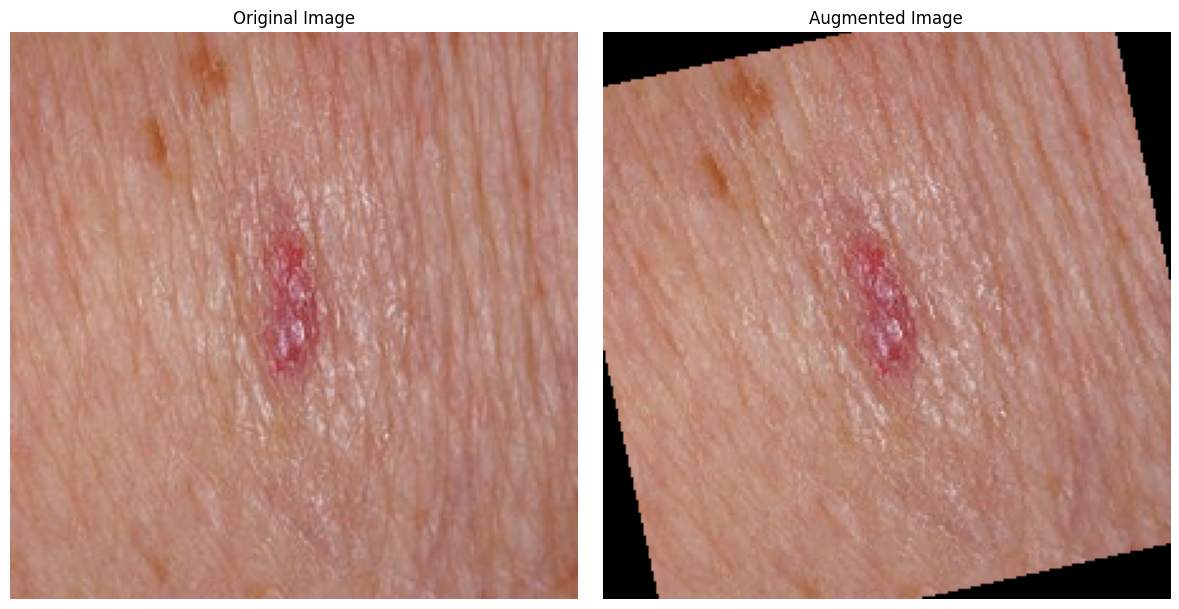

In [12]:
def show_original_and_augmented(dataset, idx, transform, fig_size=(12, 6)):
    """
    Display the original image and the augmented image side by side.
    
    Parameters:
    - dataset: The dataset containing images and labels.
    - idx: Index of the image to display.
    - transform: The transformation pipeline to apply to the image.
    - fig_size: Tuple for figure size.
    """
    # Load the original image and label
    img_path = dataset.df.iloc[idx]['image_path']
    original_image = Image.open(img_path).convert('RGB')  # Ensure it's RGB
    
    # Apply the transform to create the augmented image
    augmented_image = transform(original_image)
    
    # Convert both images to numpy arrays for visualization
    original_image_np = np.array(original_image)
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    augmented_image_np = np.clip(augmented_image_np * np.array([0.229, 0.224, 0.225]) + 
                                 np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    
    # Plot side by side
    plt.figure(figsize=fig_size)
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image_np)
    plt.title("Augmented Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
random_idx = random.randint(0, len(train_dataset) - 1)  # Get a random index
show_original_and_augmented(train_dataset, random_idx, transform=train_transforms)

# Customised blocks for Neural Networks

In [13]:
def round_channels(channels,
                   divisor=8):
    """
    Round weighted channel number (make divisible operation).

    Parameters:
    ----------
    channels : int or float
        Original number of channels.
    divisor : int, default 8
        Alignment value.

    Returns
    -------
    int
        Weighted number of channels.
    """
    rounded_channels = max(int(channels + divisor / 2.0) // divisor * divisor, divisor)
    if float(rounded_channels) < 0.9 * channels:
        rounded_channels += divisor
    return rounded_channels


class Swish(nn.Module):
    """
    Swish activation function from 'Searching for Activation Functions,' https://arxiv.org/abs/1710.05941.
    """
    def forward(self, x):
        return x * torch.sigmoid(x)


class HSigmoid(nn.Module):
    """
    Approximated sigmoid function, so-called hard-version of sigmoid from 'Searching for MobileNetV3,'
    https://arxiv.org/abs/1905.02244.
    """
    def forward(self, x):
        return F.relu6(x + 3.0, inplace=True) / 6.0


class HSwish(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=False):
        super(HSwish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3.0, inplace=self.inplace) / 6.0


def get_activation_layer(activation):
    """
    Create activation layer from string/function.

    Parameters:
    ----------
    activation : function, or str, or nn.Module
        Activation function or name of activation function.

    Returns
    -------
    nn.Module
        Activation layer.
    """
    assert (activation is not None)
    if isfunction(activation):
        return activation()
    elif isinstance(activation, str):
        if activation == "relu":
            return nn.ReLU(inplace=True)
        elif activation == "relu6":
            return nn.ReLU6(inplace=True)
        elif activation == "swish":
            return Swish()
        elif activation == "hswish":
            return HSwish(inplace=True)
        elif activation == "sigmoid":
            return nn.Sigmoid()
        elif activation == "hsigmoid":
            return HSigmoid()
        else:
            raise NotImplementedError()
    else:
        assert (isinstance(activation, nn.Module))
        return activation


def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)


def conv3x3(in_channels,
            out_channels,
            stride=1,
            padding=1,
            dilation=1,
            groups=1,
            bias=False):
    """
    Convolution 3x3 layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias)


def depthwise_conv3x3(channels,
                      stride):
    """
    Depthwise convolution 3x3 layer.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    strides : int or tuple/list of 2 int
        Strides of the convolution.
    """
    return nn.Conv2d(
        in_channels=channels,
        out_channels=channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=channels,
        bias=False)


class ConvBlock(nn.Module):
    """
    Standard convolution block with Batch normalization and activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True))):
        super(ConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_bn:
            self.bn = nn.BatchNorm2d(
                num_features=out_channels,
                eps=bn_eps)
        if self.activate:
            self.activ = get_activation_layer(activation)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def conv1x1_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=0,
                  groups=1,
                  bias=False,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    1x1 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 0
        Padding value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=padding,
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def conv3x3_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=1,
                  dilation=1,
                  groups=1,
                  bias=False,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def conv5x5_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=2,
                  dilation=1,
                  groups=1,
                  bias=False,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    5x5 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 2
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


def conv7x7_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=3,
                  bias=False,
                  use_bn=True,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    7x7 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 3
        Padding value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=stride,
        padding=padding,
        bias=bias,
        use_bn=use_bn,
        activation=activation)


def dwconv_block(in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True))):
    """
    Depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=out_channels,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def dwconv3x3_block(in_channels,
                    out_channels,
                    stride=1,
                    padding=1,
                    dilation=1,
                    bias=False,
                    bn_eps=1e-5,
                    activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return dwconv_block(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


def dwconv5x5_block(in_channels,
                    out_channels,
                    stride=1,
                    padding=2,
                    dilation=1,
                    bias=False,
                    bn_eps=1e-5,
                    activation=(lambda: nn.ReLU(inplace=True))):
    """
    5x5 depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 2
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return dwconv_block(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


class DwsConvBlock(nn.Module):
    """
    Depthwise separable convolution block with BatchNorms and activations at each convolution layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    dw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the depthwise convolution block.
    pw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the pointwise convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 dw_activation=(lambda: nn.ReLU(inplace=True)),
                 pw_activation=(lambda: nn.ReLU(inplace=True))):
        super(DwsConvBlock, self).__init__()
        self.dw_conv = dwconv_block(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            use_bn=use_bn,
            bn_eps=bn_eps,
            activation=dw_activation)
        self.pw_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias,
            use_bn=use_bn,
            bn_eps=bn_eps,
            activation=pw_activation)

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x


def dwsconv3x3_block(in_channels,
                     out_channels,
                     stride=1,
                     padding=1,
                     dilation=1,
                     bias=False,
                     bn_eps=1e-5,
                     dw_activation=(lambda: nn.ReLU(inplace=True)),
                     pw_activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 depthwise separable version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    dw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the depthwise convolution block.
    pw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the pointwise convolution block.
    """
    return DwsConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        dw_activation=dw_activation,
        pw_activation=pw_activation)


class PreConvBlock(nn.Module):
    """
    Convolution block with Batch normalization and ReLU pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation. It's used by PreResNet.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 bias=False,
                 return_preact=False,
                 activate=True):
        super(PreConvBlock, self).__init__()
        self.return_preact = return_preact
        self.activate = activate

        self.bn = nn.BatchNorm2d(num_features=in_channels)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias)

    def forward(self, x):
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        if self.return_preact:
            x_pre_activ = x
        x = self.conv(x)
        if self.return_preact:
            return x, x_pre_activ
        else:
            return x


def pre_conv1x1_block(in_channels,
                      out_channels,
                      stride=1,
                      bias=False,
                      return_preact=False,
                      activate=True):
    """
    1x1 version of the pre-activated convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return PreConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        bias=bias,
        return_preact=return_preact,
        activate=activate)


def pre_conv3x3_block(in_channels,
                      out_channels,
                      stride=1,
                      padding=1,
                      dilation=1,
                      return_preact=False,
                      activate=True):
    """
    3x3 version of the pre-activated convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return PreConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        return_preact=return_preact,
        activate=activate)


def channel_shuffle(x,
                    groups):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // groups
    x = x.view(batch, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch, channels, height, width)
    return x


class ChannelShuffle(nn.Module):
    """
    Channel shuffle layer. This is a wrapper over the same operation. It is designed to save the number of groups.

    Parameters:
    ----------
    channels : int
        Number of channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 channels,
                 groups):
        super(ChannelShuffle, self).__init__()
        # assert (channels % groups == 0)
        if channels % groups != 0:
            raise ValueError('channels must be divisible by groups')
        self.groups = groups

    def forward(self, x):
        return channel_shuffle(x, self.groups)


def channel_shuffle2(x,
                     groups):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083. The alternative version.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // groups
    x = x.view(batch, channels_per_group, groups, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch, channels, height, width)
    return x


class ChannelShuffle2(nn.Module):
    """
    Channel shuffle layer. This is a wrapper over the same operation. It is designed to save the number of groups.
    The alternative version.

    Parameters:
    ----------
    channels : int
        Number of channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 channels,
                 groups):
        super(ChannelShuffle2, self).__init__()
        # assert (channels % groups == 0)
        if channels % groups != 0:
            raise ValueError('channels must be divisible by groups')
        self.groups = groups

    def forward(self, x):
        return channel_shuffle2(x, self.groups)


class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    round_mid : bool, default False
        Whether to round middle channel number (make divisible by 8).
    activation : function, or str, or nn.Module, default 'relu'
        Activation function after the first convolution.
    out_activation : function, or str, or nn.Module, default 'sigmoid'
        Activation function after the last convolution.
    """
    def __init__(self,
                 channels,
                 reduction=16,
                 round_mid=False,
                 mid_activation=(lambda: nn.ReLU(inplace=True)),
                 out_activation=(lambda: nn.Sigmoid())):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction if not round_mid else round_channels(float(channels) / reduction)

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_channels,
            bias=True)
        self.activ = get_activation_layer(mid_activation)
        self.conv2 = conv1x1(
            in_channels=mid_channels,
            out_channels=channels,
            bias=True)
        self.sigmoid = get_activation_layer(out_activation)

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class IBN(nn.Module):
    """
    Instance-Batch Normalization block from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : int
        Number of channels.
    inst_fraction : float, default 0.5
        The first fraction of channels for normalization.
    inst_first : bool, default True
        Whether instance normalization be on the first part of channels.
    """
    def __init__(self,
                 channels,
                 first_fraction=0.5,
                 inst_first=True):
        super(IBN, self).__init__()
        self.inst_first = inst_first
        h1_channels = int(math.floor(channels * first_fraction))
        h2_channels = channels - h1_channels
        self.split_sections = [h1_channels, h2_channels]

        if self.inst_first:
            self.inst_norm = nn.InstanceNorm2d(
                num_features=h1_channels,
                affine=True)
            self.batch_norm = nn.BatchNorm2d(num_features=h2_channels)
        else:
            self.batch_norm = nn.BatchNorm2d(num_features=h1_channels)
            self.inst_norm = nn.InstanceNorm2d(
                num_features=h2_channels,
                affine=True)

    def forward(self, x):
        x1, x2 = torch.split(x, split_size_or_sections=self.split_sections, dim=1)
        if self.inst_first:
            x1 = self.inst_norm(x1.contiguous())
            x2 = self.batch_norm(x2.contiguous())
        else:
            x1 = self.batch_norm(x1.contiguous())
            x2 = self.inst_norm(x2.contiguous())
        x = torch.cat((x1, x2), dim=1)
        return x


class Identity(nn.Module):
    """
    Identity block.
    """
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class DualPathSequential(nn.Sequential):
    """
    A sequential container for modules with dual inputs/outputs.
    Modules will be executed in the order they are added.

    Parameters:
    ----------
    return_two : bool, default True
        Whether to return two output after execution.
    first_ordinals : int, default 0
        Number of the first modules with single input/output.
    last_ordinals : int, default 0
        Number of the final modules with single input/output.
    dual_path_scheme : function
        Scheme of dual path response for a module.
    dual_path_scheme_ordinal : function
        Scheme of dual path response for an ordinal module.
    """
    def __init__(self,
                 return_two=True,
                 first_ordinals=0,
                 last_ordinals=0,
                 dual_path_scheme=(lambda module, x1, x2: module(x1, x2)),
                 dual_path_scheme_ordinal=(lambda module, x1, x2: (module(x1), x2))):
        super(DualPathSequential, self).__init__()
        self.return_two = return_two
        self.first_ordinals = first_ordinals
        self.last_ordinals = last_ordinals
        self.dual_path_scheme = dual_path_scheme
        self.dual_path_scheme_ordinal = dual_path_scheme_ordinal

    def forward(self, x1, x2=None):
        length = len(self._modules.values())
        for i, module in enumerate(self._modules.values()):
            if (i < self.first_ordinals) or (i >= length - self.last_ordinals):
                x1, x2 = self.dual_path_scheme_ordinal(module, x1, x2)
            else:
                x1, x2 = self.dual_path_scheme(module, x1, x2)
        if self.return_two:
            return x1, x2
        else:
            return x1


class Concurrent(nn.Sequential):
    """
    A container for concatenation of modules on the base of the sequential container.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    stack : bool, default False
        Whether to concatenate tensors along a new dimension.
    """
    def __init__(self,
                 axis=1,
                 stack=False):
        super(Concurrent, self).__init__()
        self.axis = axis
        self.stack = stack

    def forward(self, x):
        out = []
        for module in self._modules.values():
            out.append(module(x))
        if self.stack:
            out = torch.stack(tuple(out), dim=self.axis)
        else:
            out = torch.cat(tuple(out), dim=self.axis)
        return out


class ParametricSequential(nn.Sequential):
    """
    A sequential container for modules with parameters.
    Modules will be executed in the order they are added.
    """
    def __init__(self, *args):
        super(ParametricSequential, self).__init__(*args)

    def forward(self, x, **kwargs):
        for module in self._modules.values():
            x = module(x, **kwargs)
        return x


class ParametricConcurrent(nn.Sequential):
    """
    A container for concatenation of modules with parameters.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    """
    def __init__(self, axis=1):
        super(ParametricConcurrent, self).__init__()
        self.axis = axis

    def forward(self, x, **kwargs):
        out = []
        for module in self._modules.values():
            out.append(module(x, **kwargs))
        out = torch.cat(tuple(out), dim=self.axis)
        return out


class Hourglass(nn.Module):
    """
    A hourglass block.

    Parameters:
    ----------
    down_seq : nn.Sequential
        Down modules as sequential.
    up_seq : nn.Sequential
        Up modules as sequential.
    skip_seq : nn.Sequential
        Skip connection modules as sequential.
    merge_type : str, default 'add'
        Type of concatenation of up and skip outputs.
    return_first_skip : bool, default False
        Whether return the first skip connection output. Used in ResAttNet.
    """
    def __init__(self,
                 down_seq,
                 up_seq,
                 skip_seq,
                 merge_type="add",
                 return_first_skip=False):
        super(Hourglass, self).__init__()
        assert (len(up_seq) == len(down_seq))
        assert (len(skip_seq) == len(down_seq))
        assert (merge_type in ["add"])
        self.merge_type = merge_type
        self.return_first_skip = return_first_skip
        self.depth = len(down_seq)

        self.down_seq = down_seq
        self.up_seq = up_seq
        self.skip_seq = skip_seq

    def forward(self, x, **kwargs):
        y = None
        down_outs = [x]
        for down_module in self.down_seq._modules.values():
            x = down_module(x)
            down_outs.append(x)
        for i in range(len(down_outs)):
            if i != 0:
                y = down_outs[self.depth - i]
                skip_module = self.skip_seq[self.depth - i]
                y = skip_module(y)
                if (y is not None) and (self.merge_type == "add"):
                    x = x + y
            if i != len(down_outs) - 1:
                up_module = self.up_seq[self.depth - 1 - i]
                x = up_module(x)
        if self.return_first_skip:
            return x, y
        else:
            return x


class SesquialteralHourglass(nn.Module):
    """
    A sesquialteral hourglass block.

    Parameters:
    ----------
    down1_seq : nn.Sequential
        The first down modules as sequential.
    skip1_seq : nn.Sequential
        The first skip connection modules as sequential.
    up_seq : nn.Sequential
        Up modules as sequential.
    skip2_seq : nn.Sequential
        The second skip connection modules as sequential.
    down2_seq : nn.Sequential
        The second down modules as sequential.
    merge_type : str, default 'con'
        Type of concatenation of up and skip outputs.
    """
    def __init__(self,
                 down1_seq,
                 skip1_seq,
                 up_seq,
                 skip2_seq,
                 down2_seq,
                 merge_type="cat"):
        super(SesquialteralHourglass, self).__init__()
        assert (len(down1_seq) == len(up_seq))
        assert (len(down1_seq) == len(down2_seq))
        assert (len(skip1_seq) == len(skip2_seq))
        assert (len(down1_seq) == len(skip1_seq) - 1)
        assert (merge_type in ["cat", "add"])
        self.merge_type = merge_type
        self.depth = len(down1_seq)

        self.down1_seq = down1_seq
        self.skip1_seq = skip1_seq
        self.up_seq = up_seq
        self.skip2_seq = skip2_seq
        self.down2_seq = down2_seq

    def _merge(self, x, y):
        if y is not None:
            if self.merge_type == "cat":
                x = torch.cat((x, y), dim=1)
            elif self.merge_type == "add":
                x = x + y
        return x

    def forward(self, x, **kwargs):
        y = self.skip1_seq[0](x)
        skip1_outs = [y]
        for i in range(self.depth):
            x = self.down1_seq[i](x)
            y = self.skip1_seq[i + 1](x)
            skip1_outs.append(y)
        x = skip1_outs[self.depth]
        y = self.skip2_seq[0](x)
        skip2_outs = [y]
        for i in range(self.depth):
            x = self.up_seq[i](x)
            y = skip1_outs[self.depth - 1 - i]
            x = self._merge(x, y)
            y = self.skip2_seq[i + 1](x)
            skip2_outs.append(y)
        x = self.skip2_seq[self.depth](x)
        for i in range(self.depth):
            x = self.down2_seq[i](x)
            y = skip2_outs[self.depth - 1 - i]
            x = self._merge(x, y)
        return x


class MultiOutputSequential(nn.Sequential):
    """
    A sequential container with multiple outputs.
    Modules will be executed in the order they are added.
    """
    def __init__(self):
        super(MultiOutputSequential, self).__init__()

    def forward(self, x):
        outs = []
        for module in self._modules.values():
            x = module(x)
            if hasattr(module, "do_output") and module.do_output:
                outs.append(x)
        return [x] + outs


class Flatten(nn.Module):
    """
    Simple flatten module.
    """

    def forward(self, x):
        return x.view(x.size(0), -1)

# SqueezeNet

# ESPNET backbone

In [14]:
class PreActivation(nn.Module):
    """
    PreResNet like pure pre-activation block without convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PreActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class ShortcutBlock(nn.Module):
    """
    ESPNetv2 shortcut block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ShortcutBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            activation=(lambda: nn.PReLU(in_channels)))
        self.conv2 = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class HierarchicalConcurrent(nn.Sequential):
    """
    A container for hierarchical concatenation of modules on the base of the sequential container.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    """
    def __init__(self, axis=1):
        super(HierarchicalConcurrent, self).__init__()
        self.axis = axis

    def forward(self, x):
        out = []
        y_prev = None
        for module in self._modules.values():
            y = module(x)
            if y_prev is not None:
                y += y_prev
            out.append(y)
            y_prev = y
        out = torch.cat(tuple(out), dim=self.axis)
        return out


class ESPBlock(nn.Module):
    """
    ESPNetv2 block (so-called EESP block).

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the branch convolution layers.
    dilations : list of int
        Dilation values for branches.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilations):
        super(ESPBlock, self).__init__()
        num_branches = len(dilations)
        assert (out_channels % num_branches == 0)
        self.downsample = (stride != 1)
        mid_channels = out_channels // num_branches

        self.reduce_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=num_branches,
            activation=(lambda: nn.PReLU(mid_channels)))

        self.branches = HierarchicalConcurrent()
        for i in range(num_branches):
            self.branches.add_module("branch{}".format(i + 1), conv3x3(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                padding=dilations[i],
                dilation=dilations[i],
                groups=mid_channels))

        self.merge_conv = conv1x1_block(
            in_channels=out_channels,
            out_channels=out_channels,
            groups=num_branches,
            activation=None)
        self.preactiv = PreActivation(in_channels=out_channels)
        self.activ = nn.PReLU(out_channels)

    def forward(self, x, x0):
        y = self.reduce_conv(x)
        y = self.branches(y)
        y = self.preactiv(y)
        y = self.merge_conv(y)
        if not self.downsample:
            y = y + x
            y = self.activ(y)
        return y, x0


class DownsampleBlock(nn.Module):
    """
    ESPNetv2 downsample block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    x0_channels : int
        Number of input channels for shortcut.
    dilations : list of int
        Dilation values for branches in EESP block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 x0_channels,
                 dilations):
        super(DownsampleBlock, self).__init__()
        inc_channels = out_channels - in_channels

        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=2,
            padding=1)
        self.eesp = ESPBlock(
            in_channels=in_channels,
            out_channels=inc_channels,
            stride=2,
            dilations=dilations)
        self.shortcut_block = ShortcutBlock(
            in_channels=x0_channels,
            out_channels=out_channels)
        self.activ = nn.PReLU(out_channels)

    def forward(self, x, x0):
        y1 = self.pool(x)
        y2, _ = self.eesp(x, None)
        x = torch.cat((y1, y2), dim=1)
        x0 = self.pool(x0)
        y3 = self.shortcut_block(x0)
        x = x + y3
        x = self.activ(x)
        return x, x0


class ESPInitBlock(nn.Module):
    """
    ESPNetv2 initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ESPInitBlock, self).__init__()
        self.conv = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2,
            activation=(lambda: nn.PReLU(out_channels)))
        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x, x0):
        x = self.conv(x)
        x0 = self.pool(x0)
        return x, x0


class ESPFinalBlock(nn.Module):
    """
    ESPNetv2 final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    final_groups : int
        Number of groups in the last convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 final_groups):
        super(ESPFinalBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            groups=in_channels,
            activation=(lambda: nn.PReLU(in_channels)))
        self.conv2 = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            groups=final_groups,
            activation=(lambda: nn.PReLU(out_channels)))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ESPNetv2(nn.Module):
    """
    ESPNetv2 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural Network,'
    https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final unit.
    final_block_groups : int
        Number of groups for the final unit.
    dilations : list of list of list of int
        Dilation values for branches in each unit.
    dropout_rate : float, default 0.2
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 final_block_groups,
                 dilations,
                 dropout_rate=0.2,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ESPNetv2, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        x0_channels = in_channels

        self.features = DualPathSequential(
            return_two=False,
            first_ordinals=0,
            last_ordinals=2)
        self.features.add_module("init_block", ESPInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential()
            for j, out_channels in enumerate(channels_per_stage):
                if j == 0:
                    unit = DownsampleBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        x0_channels=x0_channels,
                        dilations=dilations[i][j])
                else:
                    unit = ESPBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=1,
                        dilations=dilations[i][j])
                stage.add_module("unit{}".format(j + 1), unit)
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", ESPFinalBlock(
            in_channels=in_channels,
            out_channels=final_block_channels,
            final_groups=final_block_groups))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x, x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_espnetv2(width_scale,
                 model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create ESPNetv2 model with specific parameters.

    Parameters:
    ----------
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    assert (width_scale <= 2.0)

    branches = 4
    layers = [1, 4, 8, 4]

    max_dilation_list = [6, 5, 4, 3, 2]
    max_dilations = [[max_dilation_list[i]] + [max_dilation_list[i + 1]] * (li - 1) for (i, li) in enumerate(layers)]
    dilations = [[sorted([k + 1 if k < dij else 1 for k in range(branches)]) for dij in di] for di in max_dilations]

    base_channels = 32
    weighed_base_channels = math.ceil(float(math.floor(base_channels * width_scale)) / branches) * branches
    channels_per_layers = [weighed_base_channels * pow(2, i + 1) for i in range(len(layers))]

    init_block_channels = base_channels if weighed_base_channels > base_channels else weighed_base_channels
    final_block_channels = 1024 if width_scale <= 1.5 else 1280

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = ESPNetv2(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        final_block_groups=branches,
        dilations=dilations,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def espnetv2(**kwargs):
    """
    ESPNetv2 x1.0 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=1.0, model_name="espnetv2_w1", **kwargs)

# SquuezeNet Backbone

In [15]:
class FireConv(nn.Module):
    """
    SqueezeNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding):
        super(FireConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        return x


class FireUnit(nn.Module):
    """
    SqueezeNet unit, so-called 'Fire' unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    squeeze_channels : int
        Number of output channels for squeeze convolution blocks.
    expand1x1_channels : int
        Number of output channels for expand 1x1 convolution blocks.
    expand3x3_channels : int
        Number of output channels for expand 3x3 convolution blocks.
    residual : bool
        Whether use residual connection.
    """
    def __init__(self,
                 in_channels,
                 squeeze_channels,
                 expand1x1_channels,
                 expand3x3_channels,
                 residual):
        super(FireUnit, self).__init__()
        self.residual = residual

        self.squeeze = FireConv(
            in_channels=in_channels,
            out_channels=squeeze_channels,
            kernel_size=1,
            padding=0)
        self.expand1x1 = FireConv(
            in_channels=squeeze_channels,
            out_channels=expand1x1_channels,
            kernel_size=1,
            padding=0)
        self.expand3x3 = FireConv(
            in_channels=squeeze_channels,
            out_channels=expand3x3_channels,
            kernel_size=3,
            padding=1)

    def forward(self, x):
        if self.residual:
            identity = x
        x = self.squeeze(x)
        y1 = self.expand1x1(x)
        y2 = self.expand3x3(x)
        out = torch.cat((y1, y2), dim=1)
        if self.residual:
            out = out + identity
        return out


class SqueezeInitBlock(nn.Module):
    """
    SqueezeNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size):
        super(SqueezeInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=2)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        return x


class SqueezeNet(nn.Module):
    """
    SqueezeNet model from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size,'
    https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    residuals : bool
        Whether to use residual units.
    init_block_kernel_size : int or tuple/list of 2 int
        The dimensions of the convolution window for the initial unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 residuals,
                 init_block_kernel_size,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", SqueezeInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            kernel_size=init_block_kernel_size))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                kernel_size=3,
                stride=2,
                ceil_mode=True))
            for j, out_channels in enumerate(channels_per_stage):
                expand_channels = out_channels // 2
                squeeze_channels = out_channels // 8
                stage.add_module("unit{}".format(j + 1), FireUnit(
                    in_channels=in_channels,
                    squeeze_channels=squeeze_channels,
                    expand1x1_channels=expand_channels,
                    expand3x3_channels=expand_channels,
                    residual=((residuals is not None) and (residuals[i][j] == 1))))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("dropout", nn.Dropout(p=0.5))

        self.output = nn.Sequential()
        self.output.add_module("final_conv", nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_classes,
            kernel_size=1))
        self.output.add_module("final_activ", nn.ReLU(inplace=True))
        self.output.add_module("final_pool", nn.AvgPool2d(
            kernel_size=13,
            stride=1))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                if 'final_conv' in name:
                    init.normal_(module.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_squeezenet(version,
                   residual=False,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create SqueezeNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of SqueezeNet ('1.0' or '1.1').
    residual : bool, default False
        Whether to use residual connections.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if version == '1.0':
        channels = [[128, 128, 256], [256, 384, 384, 512], [512]]
        residuals = [[0, 1, 0], [1, 0, 1, 0], [1]]
        init_block_kernel_size = 7
        init_block_channels = 96
    elif version == '1.1':
        channels = [[128, 128], [256, 256], [384, 384, 512, 512]]
        residuals = [[0, 1], [0, 1], [0, 1, 0, 1]]
        init_block_kernel_size = 3
        init_block_channels = 64
    else:
        raise ValueError("Unsupported SqueezeNet version {}".format(version))

    if not residual:
        residuals = None

    net = SqueezeNet(
        channels=channels,
        residuals=residuals,
        init_block_kernel_size=init_block_kernel_size,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def squeezenet(**kwargs):
    """
    SqueezeNet 'vanilla' model from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
    size,' https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenet(version="1.0", residual=False, model_name="squeezenet_v1_0", **kwargs)

# PeleeNet backbone

In [16]:
class PeleeBranch1(nn.Module):
    """
    PeleeNet branch type 1 block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the second convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 stride=1):
        super(PeleeBranch1, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=stride)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class PeleeBranch2(nn.Module):
    """
    PeleeNet branch type 2 block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels):
        super(PeleeBranch2, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.conv3 = conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class StemBlock(nn.Module):
    """
    PeleeNet stem block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(StemBlock, self).__init__()
        mid1_channels = out_channels // 2
        mid2_channels = out_channels * 2

        self.first_conv = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)

        self.branches = Concurrent()
        self.branches.add_module("branch1", PeleeBranch1(
            in_channels=out_channels,
            out_channels=out_channels,
            mid_channels=mid1_channels,
            stride=2))
        self.branches.add_module("branch2", nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0))

        self.last_conv = conv1x1_block(
            in_channels=mid2_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.first_conv(x)
        x = self.branches(x)
        x = self.last_conv(x)
        return x


class DenseBlock(nn.Module):
    """
    PeleeNet dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    bottleneck_size : int
        Bottleneck width.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 bottleneck_size):
        super(DenseBlock, self).__init__()
        inc_channels = (out_channels - in_channels) // 2
        mid_channels = inc_channels * bottleneck_size

        self.branch1 = PeleeBranch1(
            in_channels=in_channels,
            out_channels=inc_channels,
            mid_channels=mid_channels)
        self.branch2 = PeleeBranch2(
            in_channels=in_channels,
            out_channels=inc_channels,
            mid_channels=mid_channels)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x, x1, x2), dim=1)
        return x


class TransitionBlock(nn.Module):
    """
    PeleeNet's transition block, like in DensNet, but with ordinary convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels)
        self.pool = nn.AvgPool2d(
            kernel_size=2,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class PeleeNet(nn.Module):
    """
    PeleeNet model from 'Pelee: A Real-Time Object Detection System on Mobile Devices,'
    https://arxiv.org/abs/1804.06882.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck_sizes : list of int
        Bottleneck sizes for each stage.
    dropout_rate : float, default 0.5
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck_sizes,
                 dropout_rate=0.5,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(PeleeNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", StemBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            bottleneck_size = bottleneck_sizes[i]
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans{}".format(i + 1), TransitionBlock(
                    in_channels=in_channels,
                    out_channels=in_channels))
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), DenseBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    bottleneck_size=bottleneck_size))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_peleenet(model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create PeleeNet model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    init_block_channels = 32
    growth_rate = 32
    layers = [3, 4, 8, 6]
    bottleneck_sizes = [1, 2, 4, 4]

    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [reduce(
            lambda xj, yj: xj + [xj[-1] + yj],
            [growth_rate] * yi,
            [xi[-1][-1]])[1:]],
        layers,
        [[init_block_channels]])[1:]

    net = PeleeNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck_sizes=bottleneck_sizes,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def peleenet(**kwargs):
    """
    PeleeNet model from 'Pelee: A Real-Time Object Detection System on Mobile Devices,'
    https://arxiv.org/abs/1804.06882.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_peleenet(model_name="peleenet", **kwargs)


# ShuffleNet BackBone

In [17]:
class ShuffleUnit(nn.Module):
    """
    ShuffleNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int
        Number of groups in convolution layers.
    downsample : bool
        Whether do downsample.
    ignore_group : bool
        Whether ignore group value in the first convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 groups,
                 downsample,
                 ignore_group):
        super(ShuffleUnit, self).__init__()
        self.downsample = downsample
        mid_channels = out_channels // 4

        if downsample:
            out_channels -= in_channels

        self.compress_conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=(1 if ignore_group else groups))
        self.compress_bn1 = nn.BatchNorm2d(num_features=mid_channels)
        self.c_shuffle = ChannelShuffle(
            channels=mid_channels,
            groups=groups)
        self.dw_conv2 = depthwise_conv3x3(
            channels=mid_channels,
            stride=(2 if self.downsample else 1))
        self.dw_bn2 = nn.BatchNorm2d(num_features=mid_channels)
        self.expand_conv3 = conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            groups=groups)
        self.expand_bn3 = nn.BatchNorm2d(num_features=out_channels)
        if downsample:
            self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.compress_conv1(x)
        x = self.compress_bn1(x)
        x = self.activ(x)
        x = self.c_shuffle(x)
        x = self.dw_conv2(x)
        x = self.dw_bn2(x)
        x = self.expand_conv3(x)
        x = self.expand_bn3(x)
        if self.downsample:
            identity = self.avgpool(identity)
            x = torch.cat((x, identity), dim=1)
        else:
            x = x + identity
        x = self.activ(x)
        return x


class ShuffleInitBlock(nn.Module):
    """
    ShuffleNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ShuffleInitBlock, self).__init__()

        self.conv = conv3x3(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class ShuffleNet(nn.Module):
    """
    ShuffleNet model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    groups : int
        Number of groups in convolution layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 groups,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ShuffleNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ShuffleInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                downsample = (j == 0)
                ignore_group = (i == 0) and (j == 0)
                stage.add_module("unit{}".format(j + 1), ShuffleUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    groups=groups,
                    downsample=downsample,
                    ignore_group=ignore_group))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_shufflenet(groups,
                   width_scale,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create ShuffleNet model with specific parameters.

    Parameters:
    ----------
    groups : int
        Number of groups in convolution layers.
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 24
    layers = [4, 8, 4]

    if groups == 1:
        channels_per_layers = [144, 288, 576]
    elif groups == 2:
        channels_per_layers = [200, 400, 800]
    elif groups == 3:
        channels_per_layers = [240, 480, 960]
    elif groups == 4:
        channels_per_layers = [272, 544, 1088]
    elif groups == 8:
        channels_per_layers = [384, 768, 1536]
    else:
        raise ValueError("The {} of groups is not supported".format(groups))

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = int(init_block_channels * width_scale)

    net = ShuffleNet(
        channels=channels,
        init_block_channels=init_block_channels,
        groups=groups,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def shufflenet(**kwargs):
    """
    ShuffleNet 1x (g=1) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=1, width_scale=1.0, model_name="shufflenet_g1_w1", **kwargs)

# Train model function

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=CFG.EPOCHS, patience=7, min_lr=1e-6):
    best_accuracy = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize learning rate scheduler without verbose parameter
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=3, min_lr=min_lr
    )
    
    # Early stopping parameters
    early_stopping_patience = patience
    early_stopping_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Print metrics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
        
        # Print confusion matrix every 5 epochs
        # if epoch % 5 == 0:
        #     cm = confusion_matrix(val_labels, val_preds)
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_accuracy)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Only print LR changes when they occur
        if old_lr != new_lr:
            print(f"Learning rate decreased from {old_lr:.6f} to {new_lr:.6f}")
        
        # Save the best model and update early stopping
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        # Early stopping check
        # if early_stopping_counter >= early_stopping_patience:
        #     print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        #     break
            
        # If learning rate is too small, stop training
        if new_lr <= min_lr:
            print(f"\nLearning rate {new_lr:.6f} is too small. Stopping training!")
            break
    
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    return best_accuracy

# Baseline of All models

 | Model         | Parameters | Accuracy |
|---------------|------------|----------|
| ESPNetv2_w1   | 647,122    | 0.8545   |
| SqueezeNet    | 736,450    | 0.8424   |
| PeleeNet      | 2,098,658  | 0.8470   |
| ShuffleNet    | 956,090    | 0.8424   |


In [19]:
all_result = {}

# Experiment 1 [ESPnet + CBAM attention + Residual Block] Less Params Ver.

In [20]:
import torch
import torch.nn as nn
import math
from torch.nn import init

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.shared_mlp = nn.Sequential(
            conv1x1(channels, channels // reduction_ratio, bias=True),
            nn.ReLU(inplace=True),
            conv1x1(channels // reduction_ratio, channels, bias=True)
        )
        
    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        out = torch.sigmoid(avg_out + max_out)
        return out

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = conv3x3_block(2, 1, activation=None)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention()
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class LightESPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilations=[1,2,4,8]):
        super(LightESPBlock, self).__init__()
        num_branches = len(dilations)
        mid_channels = out_channels // num_branches
        
        self.reduce_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=1,
            activation=(lambda: nn.ReLU(inplace=True))
        )
        
        self.branches = HierarchicalConcurrent()
        for i, dilation in enumerate(dilations):
            self.branches.add_module(
                f"branch{i+1}",
                conv3x3(
                    in_channels=mid_channels,
                    out_channels=mid_channels,
                    stride=stride,
                    padding=dilation,
                    dilation=dilation,
                    groups=mid_channels
                )
            )
            
        self.merge_conv = conv1x1_block(
            in_channels=out_channels,
            out_channels=out_channels,
            activation=None
        )
        
        self.cbam = CBAM(out_channels)
        self.activ = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        x = self.reduce_conv(x)
        x = self.branches(x)
        x = self.merge_conv(x)
        x = self.cbam(x)
        
        if x.shape == identity.shape:
            x = x + identity
        x = self.activ(x)
        return x

class DownsampleUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsampleUnit, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv = LightESPBlock(in_channels, out_channels)
        
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class LightweightModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000):
        super(LightweightModel, self).__init__()
        
        # Initial convolution block
        self.init_block = conv3x3_block(
            in_channels=in_channels,
            out_channels=32,
            stride=2
        )
        
        # Main feature extraction blocks
        self.stage1 = nn.Sequential(
            LightESPBlock(32, 64),
            LightESPBlock(64, 64)
        )
        
        self.stage2 = nn.Sequential(
            DownsampleUnit(64, 128),
            LightESPBlock(128, 128)
        )
        
        self.stage3 = nn.Sequential(
            DownsampleUnit(128, 256),
            LightESPBlock(256, 256)
        )
        
        # Final blocks
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_classes)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.01)
                init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.init_block(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

def create_model_1(num_classes=1000, pretrained=False):
    model = LightweightModel(num_classes=num_classes)
    if pretrained:
        raise ValueError("Pretrained model is not available")
    return model

In [21]:
# Initialize model
model = create_model_1(pretrained=False, num_classes=2) 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experiment 1 [ESPnet + CBAM attention + Residual Block] Less Params Ver."
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

238610
Epoch 1/30
Train Loss: 0.6761, Train Acc: 0.6635, Train F1: 0.6588
Val Loss: 0.6308, Val Acc: 0.7424, Val F1: 0.7293
Epoch 2/30
Train Loss: 0.5600, Train Acc: 0.7791, Train F1: 0.7796
Val Loss: 0.5064, Val Acc: 0.7778, Val F1: 0.7729
Epoch 3/30
Train Loss: 0.4724, Train Acc: 0.7996, Train F1: 0.7996
Val Loss: 0.4263, Val Acc: 0.7955, Val F1: 0.7939
Epoch 4/30
Train Loss: 0.4274, Train Acc: 0.8023, Train F1: 0.8023
Val Loss: 0.3775, Val Acc: 0.8460, Val F1: 0.8463
Epoch 5/30
Train Loss: 0.4120, Train Acc: 0.7988, Train F1: 0.7987
Val Loss: 0.4027, Val Acc: 0.8030, Val F1: 0.8014
Epoch 6/30
Train Loss: 0.4073, Train Acc: 0.8077, Train F1: 0.8077
Val Loss: 0.3751, Val Acc: 0.8258, Val F1: 0.8259
Epoch 7/30
Train Loss: 0.3987, Train Acc: 0.8126, Train F1: 0.8125
Val Loss: 0.3578, Val Acc: 0.8510, Val F1: 0.8513
Epoch 8/30
Train Loss: 0.3856, Train Acc: 0.8188, Train F1: 0.8187
Val Loss: 0.3677, Val Acc: 0.8333, Val F1: 0.8335
Epoch 9/30
Train Loss: 0.3872, Train Acc: 0.8162, Train F

# Experiment 2 [ESPnet + CBAM attention + Residual Block] - More Params Ver.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.nn import init

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class EnhancedESPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilations=[1,2,4,8]):
        super(EnhancedESPBlock, self).__init__()
        self.downsample = (stride != 1)
        num_branches = len(dilations)
        mid_channels = out_channels // num_branches
        
        # Point-wise reduction
        self.reduce = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=num_branches,
            activation=(lambda: nn.ReLU(inplace=True))
        )
        
        # Dilated convolutions
        self.branches = nn.ModuleList([
            conv3x3(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                padding=dilations[i],
                dilation=dilations[i],
                groups=mid_channels
            ) for i in range(num_branches)
        ])
        
        # Point-wise expansion
        self.expand = conv1x1_block(
            in_channels=out_channels,
            out_channels=out_channels,
            groups=num_branches,
            activation=None
        )
        
        # CBAM attention
        self.cbam = CBAM(out_channels)
        
        # Residual connection
        if self.downsample or in_channels != out_channels:
            self.shortcut = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None
            )
        else:
            self.shortcut = None
            
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        
        # ESP path
        x = self.reduce(x)
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        x = torch.cat(outputs, dim=1)
        x = self.expand(x)
        
        # Apply CBAM
        x = self.cbam(x)
        
        # Residual connection
        if self.shortcut is not None:
            identity = self.shortcut(identity)
        
        x += identity
        x = self.relu(x)
        
        return x

class EnhancedESPNet(nn.Module):
    def __init__(self, num_classes=1000, input_channels=3):
        super(EnhancedESPNet, self).__init__()
        
        # Initial convolution
        self.stem = nn.Sequential(
            conv3x3_block(
                in_channels=input_channels,
                out_channels=32,
                stride=2
            ),
            conv3x3_block(
                in_channels=32,
                out_channels=64,
                stride=2
            )
        )
        
        # Enhanced ESP stages
        self.stage1 = self._make_stage(64, 128, blocks=3, stride=2)
        self.stage2 = self._make_stage(128, 256, blocks=7, stride=2)
        self.stage3 = self._make_stage(256, 512, blocks=3, stride=2)
        
        # Global features
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(512, num_classes)
        
        self._initialize_weights()
        
    def _make_stage(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(EnhancedESPBlock(
            in_channels, 
            out_channels,
            stride=stride,
            dilations=[1,2,4,8]
        ))
        
        for i in range(1, blocks):
            layers.append(EnhancedESPBlock(
                out_channels,
                out_channels,
                stride=1,
                dilations=[1,2,4,8]
            ))
            
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, 0, 0.01)
                init.constant_(m.bias, 0)
                
    def forward(self, x):
        # Stem
        x = self.stem(x)
        
        # Enhanced ESP stages
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

def create_model_2(num_classes=2, input_channels=3):
    """
    Creates an enhanced version of ESPNet with CBAM attention and residual connections
    
    Args:
        num_classes: number of classification classes
        input_channels: number of input channels (3 for RGB)
    
    Returns:
        EnhancedESPNet model instance
    """
    model = EnhancedESPNet(
        num_classes=num_classes,
        input_channels=input_channels
    )
    return model

In [23]:
# Initialize model
model = create_model_2(num_classes=2, input_channels=3) 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experiment 2 [ESPnet + CBAM attention + Residual Block] - More Params Ver."
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

793820
Epoch 1/30
Train Loss: 0.5716, Train Acc: 0.7251, Train F1: 0.7236
Val Loss: 0.4149, Val Acc: 0.8131, Val F1: 0.8135
Epoch 2/30
Train Loss: 0.4201, Train Acc: 0.7912, Train F1: 0.7912
Val Loss: 0.3775, Val Acc: 0.8182, Val F1: 0.8186
Epoch 3/30
Train Loss: 0.4171, Train Acc: 0.8005, Train F1: 0.8006
Val Loss: 0.3713, Val Acc: 0.8283, Val F1: 0.8283
Epoch 4/30
Train Loss: 0.4002, Train Acc: 0.8121, Train F1: 0.8125
Val Loss: 0.3539, Val Acc: 0.8460, Val F1: 0.8462
Epoch 5/30
Train Loss: 0.3875, Train Acc: 0.8144, Train F1: 0.8146
Val Loss: 0.3675, Val Acc: 0.8434, Val F1: 0.8436
Epoch 6/30
Train Loss: 0.3761, Train Acc: 0.8170, Train F1: 0.8173
Val Loss: 0.3445, Val Acc: 0.8485, Val F1: 0.8488
Epoch 7/30
Train Loss: 0.3815, Train Acc: 0.8157, Train F1: 0.8156
Val Loss: 0.3449, Val Acc: 0.8485, Val F1: 0.8485
Epoch 8/30
Train Loss: 0.3668, Train Acc: 0.8260, Train F1: 0.8262
Val Loss: 0.3324, Val Acc: 0.8561, Val F1: 0.8563
Epoch 9/30
Train Loss: 0.3485, Train Acc: 0.8273, Train F

# Experiment 3 [ESPnet + SqueezeNet + CBAM attention + Residual Block]

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        mid_channels = max(8, channels // reduction_ratio)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(channels, mid_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, channels, 1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = torch.sigmoid(avg_out + max_out)
        return out

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = torch.sigmoid(self.conv(x))
        return x

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention()
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class LightFireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(LightFireModule, self).__init__()
        
        # Squeeze
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channels, squeeze_channels, 1),
            nn.BatchNorm2d(squeeze_channels),
            nn.ReLU(inplace=True)
        )
        
        # Expand
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels//2, 1),
            nn.BatchNorm2d(expand_channels//2),
            nn.ReLU(inplace=True)
        )
        
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels//2, 3, padding=1),
            nn.BatchNorm2d(expand_channels//2),
            nn.ReLU(inplace=True)
        )
        
        # CBAM
        self.cbam = CBAM(expand_channels)

        # Projection for residual if needed
        self.projection = None
        if in_channels != expand_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, bias=False),
                nn.BatchNorm2d(expand_channels)
            )
        
    def forward(self, x):
        identity = x
        
        x = self.squeeze(x)
        x = torch.cat([self.expand1x1(x), self.expand3x3(x)], 1)
        x = self.cbam(x)
        
        if self.projection is not None:
            identity = self.projection(identity)
        
        x = x + identity
        return x

class EfficientSpatialBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates=[1,2,4]):
        super(EfficientSpatialBlock, self).__init__()
        
        self.reduce = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )
        
        self.branches = nn.ModuleList([
            nn.Conv2d(out_channels//4, out_channels//4, 3, 
                     padding=rate, dilation=rate, groups=out_channels//4)
            for rate in dilation_rates
        ])
        
        self.merge = nn.Sequential(
            nn.Conv2d(out_channels//4 * len(dilation_rates), out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.cbam = CBAM(out_channels)
        
        # Projection for residual if needed
        self.projection = None
        if in_channels != out_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        x = self.reduce(x)
        branches = [branch(x) for branch in self.branches]
        x = torch.cat(branches, 1)
        x = self.merge(x)
        x = self.cbam(x)
        
        if self.projection is not None:
            identity = self.projection(identity)
            
        x = x + identity
        return x

class LightSpeedNet(nn.Module):
    def __init__(self, num_classes=1000, input_channels=3):
        super(LightSpeedNet, self).__init__()
        
        # Initial convolution
        self.init_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # Stage 1: Light Fire Modules
        self.stage1 = nn.Sequential(
            LightFireModule(32, 16, 64),
            LightFireModule(64, 24, 64)
        )
        
        # Transition 1
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            EfficientSpatialBlock(64, 128)
        )
        
        # Stage 2: Mixed Modules
        self.stage2 = nn.Sequential(
            LightFireModule(128, 32, 128),
            EfficientSpatialBlock(128, 128),
            LightFireModule(128, 32, 128)
        )
        
        # Transition 2
        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            EfficientSpatialBlock(128, 256)
        )
        
        # Stage 3: Final Processing
        self.stage3 = nn.Sequential(
            LightFireModule(256, 48, 256),
            EfficientSpatialBlock(256, 256),
            nn.Conv2d(256, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Global Features
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, num_classes)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.init_conv(x)
        x = self.stage1(x)
        x = self.trans1(x)
        x = self.stage2(x)
        x = self.trans2(x)
        x = self.stage3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x


def create_model_3(num_classes=2, input_channels=3):
    """
    Create LightSpeedNet model.
    
    Parameters:
    ----------
    num_classes : int, default 1000
        Number of classification classes.
    input_channels : int, default 3
        Number of input channels.
    """
    return LightSpeedNet(num_classes=num_classes, input_channels=input_channels)

In [25]:
# Initialize model
model = create_model_3(num_classes=2, input_channels=3) 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experiment 3 [ESPnet + SqueezeNet + CBAM attention + Residual Block]"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

516540
Epoch 1/30
Train Loss: 0.5410, Train Acc: 0.7421, Train F1: 0.7411
Val Loss: 0.4230, Val Acc: 0.8106, Val F1: 0.8110
Epoch 2/30
Train Loss: 0.4504, Train Acc: 0.7840, Train F1: 0.7835
Val Loss: 0.3952, Val Acc: 0.8308, Val F1: 0.8311
Epoch 3/30
Train Loss: 0.4229, Train Acc: 0.7938, Train F1: 0.7938
Val Loss: 0.3746, Val Acc: 0.8359, Val F1: 0.8362
Epoch 4/30
Train Loss: 0.4178, Train Acc: 0.7974, Train F1: 0.7977
Val Loss: 0.3559, Val Acc: 0.8409, Val F1: 0.8412
Epoch 5/30
Train Loss: 0.4101, Train Acc: 0.7979, Train F1: 0.7978
Val Loss: 0.3612, Val Acc: 0.8384, Val F1: 0.8386
Epoch 6/30
Train Loss: 0.3950, Train Acc: 0.8081, Train F1: 0.8083
Val Loss: 0.3438, Val Acc: 0.8687, Val F1: 0.8689
Epoch 7/30
Train Loss: 0.3832, Train Acc: 0.8121, Train F1: 0.8124
Val Loss: 0.3474, Val Acc: 0.8535, Val F1: 0.8538
Epoch 8/30
Train Loss: 0.3765, Train Acc: 0.8170, Train F1: 0.8173
Val Loss: 0.3473, Val Acc: 0.8611, Val F1: 0.8614
Epoch 9/30
Train Loss: 0.3612, Train Acc: 0.8260, Train F

# Experiment 4 [ESPnet + SqueezeNet + CBAM attention + Residual Block + SE block]

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SEBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        mid_channels = max(8, channels // reduction_ratio)
        
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Conv2d(channels, mid_channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, channels, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x)
        y = self.excitation(y)
        return x * y

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        mid_channels = max(8, channels // reduction_ratio)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(channels, mid_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, channels, 1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = torch.sigmoid(avg_out + max_out)
        return out

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = torch.sigmoid(self.conv(x))
        return x

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction_ratio)
        self.spatial_att = SpatialAttention()
        
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x

class DualAttentionBlock(nn.Module):
    """Combines SE and CBAM attention"""
    def __init__(self, channels, reduction_ratio=16):
        super(DualAttentionBlock, self).__init__()
        self.se = SEBlock(channels, reduction_ratio)
        self.cbam = CBAM(channels, reduction_ratio)
        
    def forward(self, x):
        x = self.se(x)
        x = self.cbam(x)
        return x

class LightFireModule(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand_channels):
        super(LightFireModule, self).__init__()
        
        # Squeeze
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_channels, squeeze_channels, 1),
            nn.BatchNorm2d(squeeze_channels),
            nn.ReLU(inplace=True)
        )
        
        # Expand
        self.expand1x1 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels//2, 1),
            nn.BatchNorm2d(expand_channels//2),
            nn.ReLU(inplace=True)
        )
        
        self.expand3x3 = nn.Sequential(
            nn.Conv2d(squeeze_channels, expand_channels//2, 3, padding=1),
            nn.BatchNorm2d(expand_channels//2),
            nn.ReLU(inplace=True)
        )
        
        # Dual Attention
        self.attention = DualAttentionBlock(expand_channels)

        # Projection for residual if needed
        self.projection = None
        if in_channels != expand_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, expand_channels, 1, bias=False),
                nn.BatchNorm2d(expand_channels)
            )
        
    def forward(self, x):
        identity = x
        
        x = self.squeeze(x)
        x = torch.cat([self.expand1x1(x), self.expand3x3(x)], 1)
        x = self.attention(x)
        
        if self.projection is not None:
            identity = self.projection(identity)
        
        x = x + identity
        return x

class EfficientSpatialBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates=[1,2,4]):
        super(EfficientSpatialBlock, self).__init__()
        
        self.reduce = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True)
        )
        
        self.branches = nn.ModuleList([
            nn.Conv2d(out_channels//4, out_channels//4, 3, 
                     padding=rate, dilation=rate, groups=out_channels//4)
            for rate in dilation_rates
        ])
        
        self.merge = nn.Sequential(
            nn.Conv2d(out_channels//4 * len(dilation_rates), out_channels, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Dual Attention
        self.attention = DualAttentionBlock(out_channels)
        
        # Projection for residual if needed
        self.projection = None
        if in_channels != out_channels:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = x
        
        x = self.reduce(x)
        branches = [branch(x) for branch in self.branches]
        x = torch.cat(branches, 1)
        x = self.merge(x)
        x = self.attention(x)
        
        if self.projection is not None:
            identity = self.projection(identity)
            
        x = x + identity
        return x

class LightSpeedNetV2(nn.Module):
    def __init__(self, num_classes=1000, input_channels=3):
        super(LightSpeedNetV2, self).__init__()
        
        # Initial convolution with SE
        self.init_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            SEBlock(32)
        )
        
        # Stage 1: Light Fire Modules
        self.stage1 = nn.Sequential(
            LightFireModule(32, 16, 64),
            LightFireModule(64, 24, 64)
        )
        
        # Transition 1
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            EfficientSpatialBlock(64, 128)
        )
        
        # Stage 2: Mixed Modules with increased width
        self.stage2 = nn.Sequential(
            LightFireModule(128, 32, 128),
            EfficientSpatialBlock(128, 128),
            LightFireModule(128, 32, 128)
        )
        
        # Transition 2 with attention
        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            EfficientSpatialBlock(128, 256),
            SEBlock(256)
        )
        
        # Stage 3: Final Processing with enhanced attention
        self.stage3 = nn.Sequential(
            LightFireModule(256, 48, 256),
            EfficientSpatialBlock(256, 256),
            DualAttentionBlock(256),
            nn.Conv2d(256, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        
        # Global Features
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(512, num_classes)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.init_conv(x)
        x = self.stage1(x)
        x = self.trans1(x)
        x = self.stage2(x)
        x = self.trans2(x)
        x = self.stage3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x
        
def create_model_4(num_classes=2, input_channels=3):
    """
    Create LightSpeedNet model.
    
    Parameters:
    ----------
    num_classes : int, default 1000
        Number of classification classes.
    input_channels : int, default 3
        Number of input channels.
    """
    return LightSpeedNetV2(num_classes=num_classes, input_channels=input_channels)



In [27]:
# Initialize model
model = create_model_4(num_classes=2, input_channels=3) 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experiment 4 [ESPnet + SqueezeNet + CBAM attention + Residual Block + SE block]"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

611942
Epoch 1/30
Train Loss: 0.5731, Train Acc: 0.7251, Train F1: 0.7214
Val Loss: 0.4655, Val Acc: 0.7929, Val F1: 0.7932
Epoch 2/30
Train Loss: 0.4549, Train Acc: 0.7867, Train F1: 0.7862
Val Loss: 0.4042, Val Acc: 0.8359, Val F1: 0.8362
Epoch 3/30
Train Loss: 0.4201, Train Acc: 0.7912, Train F1: 0.7906
Val Loss: 0.3802, Val Acc: 0.8384, Val F1: 0.8384
Epoch 4/30
Train Loss: 0.3984, Train Acc: 0.7988, Train F1: 0.7984
Val Loss: 0.3581, Val Acc: 0.8535, Val F1: 0.8538
Epoch 5/30
Train Loss: 0.3896, Train Acc: 0.8054, Train F1: 0.8046
Val Loss: 0.3861, Val Acc: 0.8460, Val F1: 0.8463
Epoch 6/30
Train Loss: 0.3653, Train Acc: 0.8286, Train F1: 0.8286
Val Loss: 0.3676, Val Acc: 0.8510, Val F1: 0.8512
Epoch 7/30
Train Loss: 0.3646, Train Acc: 0.8220, Train F1: 0.8221
Val Loss: 0.3506, Val Acc: 0.8561, Val F1: 0.8562
Epoch 8/30
Train Loss: 0.3444, Train Acc: 0.8304, Train F1: 0.8305
Val Loss: 0.3429, Val Acc: 0.8535, Val F1: 0.8536
Epoch 9/30
Train Loss: 0.3521, Train Acc: 0.8224, Train F

# Experiment 5 [ESPnet + PeleeNet + CBAM + Residual]

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.shared_mlp = nn.Sequential(
            conv1x1(channels, channels // reduction_ratio, bias=True),
            nn.ReLU(inplace=True),
            conv1x1(channels // reduction_ratio, channels, bias=True)
        )
        
    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        out = torch.sigmoid(avg_out + max_out)
        return out

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = conv3x3_block(2, 1, activation=None)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return torch.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

class LightweightESPBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(LightweightESPBlock, self).__init__()
        self.downsample = (stride != 1)
        groups = 4
        mid_channels = out_channels // groups
        
        self.reduce = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=groups)
        
        self.branches = HierarchicalConcurrent()
        dilations = [1, 2, 4, 8]
        for i, dilation in enumerate(dilations):
            self.branches.add_module(f"branch{i+1}", 
                conv3x3(
                    in_channels=mid_channels,
                    out_channels=mid_channels,
                    stride=stride,
                    padding=dilation,
                    dilation=dilation,
                    groups=mid_channels))
                    
        self.merge = conv1x1_block(
            in_channels=out_channels,
            out_channels=out_channels,
            groups=groups,
            activation=None)
            
        self.cbam = CBAM(out_channels)
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        else:
            self.shortcut = None
            
        self.activ = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        
        x = self.reduce(x)
        x = self.branches(x)
        x = self.merge(x)
        x = self.cbam(x)
        
        if self.shortcut is not None:
            identity = self.shortcut(identity)
            
        x = x + identity
        x = self.activ(x)
        return x

class DenseTransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseTransitionBlock, self).__init__()
        self.conv = conv1x1_block(in_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class HybridLightNet(nn.Module):
    def __init__(self,
                 channels=[32, 64, 128, 256],
                 init_block_channels=32,
                 dropout_rate=0.2,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=2):
        super(HybridLightNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        # Initial convolution block
        self.init_block = conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels,
            stride=2)
            
        # Stages
        self.stages = nn.Sequential()
        in_channels = init_block_channels
        for i, out_channels in enumerate(channels):
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans", DenseTransitionBlock(
                    in_channels=in_channels,
                    out_channels=out_channels))
                in_channels = out_channels
            
            # Each stage has 2-4 ESP blocks depending on depth
            num_blocks = i + 2
            for j in range(num_blocks):
                stage.add_module(f"unit{j+1}", LightweightESPBlock(
                    in_channels=in_channels,
                    out_channels=out_channels))
                in_channels = out_channels
                
            self.stages.add_module(f"stage{i+1}", stage)

        # Final blocks
        self.final_block = conv1x1_block(
            in_channels=in_channels,
            out_channels=2*in_channels)
            
        self.final_pool = nn.AdaptiveAvgPool2d(1)
        
        self.output = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(
                in_features=2*in_channels,
                out_features=num_classes)
        )
        
        self._init_params()
        
    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
                    
    def forward(self, x):
        x = self.init_block(x)
        x = self.stages(x)
        x = self.final_block(x)
        x = self.final_pool(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

def get_hybridlightnet(width_scale=1.0, model_name=None, pretrained=False, **kwargs):
    """
    Create HybridLightNet model with specific parameters.
    """
    channels = [
        int(32 * width_scale),
        int(64 * width_scale),
        int(128 * width_scale),
        int(256 * width_scale)
    ]
    
    init_block_channels = int(32 * width_scale)
    
    net = HybridLightNet(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)
        
    return net

def create_model_5(**kwargs):
    """
    HybridLightNet model for image classification.
    """
    return get_hybridlightnet(width_scale=1.0, model_name="hybridlightnet", **kwargs)

In [29]:
# Initialize model
model = create_model_5() 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experiment 5 [ESPnet + PeleeNet + CBAM + Residual]"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

382266
Epoch 1/30
Train Loss: 0.5498, Train Acc: 0.7349, Train F1: 0.7341
Val Loss: 0.4132, Val Acc: 0.8207, Val F1: 0.8210
Epoch 2/30
Train Loss: 0.4472, Train Acc: 0.7822, Train F1: 0.7824
Val Loss: 0.3808, Val Acc: 0.8308, Val F1: 0.8311
Epoch 3/30
Train Loss: 0.4262, Train Acc: 0.7974, Train F1: 0.7978
Val Loss: 0.3754, Val Acc: 0.8308, Val F1: 0.8310
Epoch 4/30
Train Loss: 0.4052, Train Acc: 0.8050, Train F1: 0.8051
Val Loss: 0.3781, Val Acc: 0.8510, Val F1: 0.8512
Epoch 5/30
Train Loss: 0.3940, Train Acc: 0.8095, Train F1: 0.8097
Val Loss: 0.3732, Val Acc: 0.8434, Val F1: 0.8436
Epoch 6/30
Train Loss: 0.3912, Train Acc: 0.8095, Train F1: 0.8097
Val Loss: 0.3802, Val Acc: 0.8460, Val F1: 0.8458
Epoch 7/30
Train Loss: 0.3699, Train Acc: 0.8202, Train F1: 0.8204
Val Loss: 0.3838, Val Acc: 0.8485, Val F1: 0.8486
Epoch 8/30
Train Loss: 0.3853, Train Acc: 0.8139, Train F1: 0.8143
Val Loss: 0.3797, Val Acc: 0.8485, Val F1: 0.8485
Learning rate decreased from 0.000100 to 0.000010
Epoch 9

# Experinent 6 [PeleeNet + CBAM + Residual Block]

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            conv1x1(channels, channels // reduction_ratio, bias=True),
            nn.ReLU(inplace=True),
            conv1x1(channels // reduction_ratio, channels, bias=True)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = torch.sigmoid(avg_out + max_out)
        return out

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = conv3x3_block(2, 1, activation=None)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(channels, reduction_ratio)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, x):
        out = x * self.channel_attention(x)
        out = out * self.spatial_attention(out)
        return out

class EnhancedDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, bottleneck_ratio=4):
        super(EnhancedDenseBlock, self).__init__()
        bottleneck_channels = growth_rate * bottleneck_ratio
        
        self.branch1 = nn.Sequential(
            conv1x1_block(in_channels, bottleneck_channels),
            conv3x3_block(bottleneck_channels, growth_rate)
        )
        
        self.branch2 = nn.Sequential(
            conv1x1_block(in_channels, bottleneck_channels),
            conv3x3_block(bottleneck_channels, growth_rate),
            conv3x3_block(growth_rate, growth_rate)
        )
        
        self.cbam = CBAMBlock(growth_rate * 2)
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        out = torch.cat([branch1, branch2], dim=1)
        out = self.cbam(out)
        out = torch.cat([x, out], dim=1)
        return out

class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = conv1x1_block(in_channels, out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InitialBlock, self).__init__()
        self.conv1 = conv3x3_block(in_channels, out_channels // 2, stride=2)
        self.conv2 = conv3x3_block(out_channels // 2, out_channels, stride=2)
        self.cbam = CBAMBlock(out_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.cbam(x)
        return x

class EnhancedNetwork(nn.Module):
    def __init__(self,
                 in_channels=3,
                 init_channels=32,
                 growth_rate=32,
                 block_config=(3, 4, 8, 6),
                 num_classes=1000):
        super(EnhancedNetwork, self).__init__()
        
        channels = init_channels
        
        # Initial Convolution
        self.features = nn.Sequential()
        self.features.add_module("init_block", InitialBlock(in_channels, channels))
        
        # Dense Blocks
        for i, num_layers in enumerate(block_config):
            block = nn.Sequential()
            for j in range(num_layers):
                block.add_module(f"dense_layer_{j+1}", EnhancedDenseBlock(
                    channels,
                    growth_rate
                ))
                channels += growth_rate * 2
                
            self.features.add_module(f"dense_block_{i+1}", block)
            
            # Add transition layer between dense blocks
            if i != len(block_config) - 1:
                out_channels = channels // 2
                self.features.add_module(f"transition_{i+1}",
                    TransitionBlock(channels, out_channels))
                channels = out_channels
        
        # Final Layers
        self.features.add_module("final_bn", nn.BatchNorm2d(channels))
        self.features.add_module("final_relu", nn.ReLU(inplace=True))
        self.features.add_module("final_pool", nn.AdaptiveAvgPool2d((1, 1)))
        
        # Classification Layer
        self.output = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(channels, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

def create_model_6(num_classes=2, **kwargs):
    """
    Create an instance of the enhanced network.
    
    Parameters:
    ----------
    num_classes : int, default 1000
        Number of classification classes.
    """
    return EnhancedNetwork(
        in_channels=3,
        init_channels=32,
        growth_rate=32,
        block_config=(3, 4, 8, 6),
        num_classes=num_classes,
        **kwargs
    )

In [31]:
# Initialize model
model = create_model_6() 
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters

model_name = "Experinent 6 [PeleeNet + CBAM + Residual Block]"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

4016344
Epoch 1/30
Train Loss: 0.5225, Train Acc: 0.7573, Train F1: 0.7574
Val Loss: 0.4423, Val Acc: 0.8106, Val F1: 0.8107
Epoch 2/30
Train Loss: 0.4241, Train Acc: 0.7952, Train F1: 0.7951
Val Loss: 0.3915, Val Acc: 0.8232, Val F1: 0.8235
Epoch 3/30
Train Loss: 0.4021, Train Acc: 0.8063, Train F1: 0.8064
Val Loss: 0.3754, Val Acc: 0.8434, Val F1: 0.8437
Epoch 4/30
Train Loss: 0.3973, Train Acc: 0.8095, Train F1: 0.8095
Val Loss: 0.3899, Val Acc: 0.8460, Val F1: 0.8463
Epoch 5/30
Train Loss: 0.3705, Train Acc: 0.8188, Train F1: 0.8191
Val Loss: 0.3705, Val Acc: 0.8333, Val F1: 0.8335
Epoch 6/30
Train Loss: 0.3635, Train Acc: 0.8233, Train F1: 0.8236
Val Loss: 0.3567, Val Acc: 0.8611, Val F1: 0.8614
Epoch 7/30
Train Loss: 0.3556, Train Acc: 0.8242, Train F1: 0.8244
Val Loss: 0.3960, Val Acc: 0.8283, Val F1: 0.8284
Epoch 8/30
Train Loss: 0.3586, Train Acc: 0.8318, Train F1: 0.8321
Val Loss: 0.3722, Val Acc: 0.8586, Val F1: 0.8589
Epoch 9/30
Train Loss: 0.3401, Train Acc: 0.8371, Train 

In [32]:
print(all_result)
all_result

{'Experiment 1 [ESPnet + CBAM attention + Residual Block] Less Params Ver.': {'num_params': 238610, 'test_accuracy': tensor(0.8318, device='cuda:0', dtype=torch.float64)}, 'Experiment 2 [ESPnet + CBAM attention + Residual Block] - More Params Ver.': {'num_params': 793820, 'test_accuracy': tensor(0.8364, device='cuda:0', dtype=torch.float64)}, 'Experiment 3 [ESPnet + SqueezeNet + CBAM attention + Residual Block]': {'num_params': 516540, 'test_accuracy': tensor(0.8439, device='cuda:0', dtype=torch.float64)}, 'Experiment 4 [ESPnet + SqueezeNet + CBAM attention + Residual Block + SE block]': {'num_params': 611942, 'test_accuracy': tensor(0.8455, device='cuda:0', dtype=torch.float64)}, 'Experiment 5 [ESPnet + PeleeNet + CBAM + Residual]': {'num_params': 382266, 'test_accuracy': tensor(0.8424, device='cuda:0', dtype=torch.float64)}, 'Experinent 6 [PeleeNet + CBAM + Residual Block]': {'num_params': 4016344, 'test_accuracy': tensor(0.8485, device='cuda:0', dtype=torch.float64)}}


Sorted Accuracy Comparison:


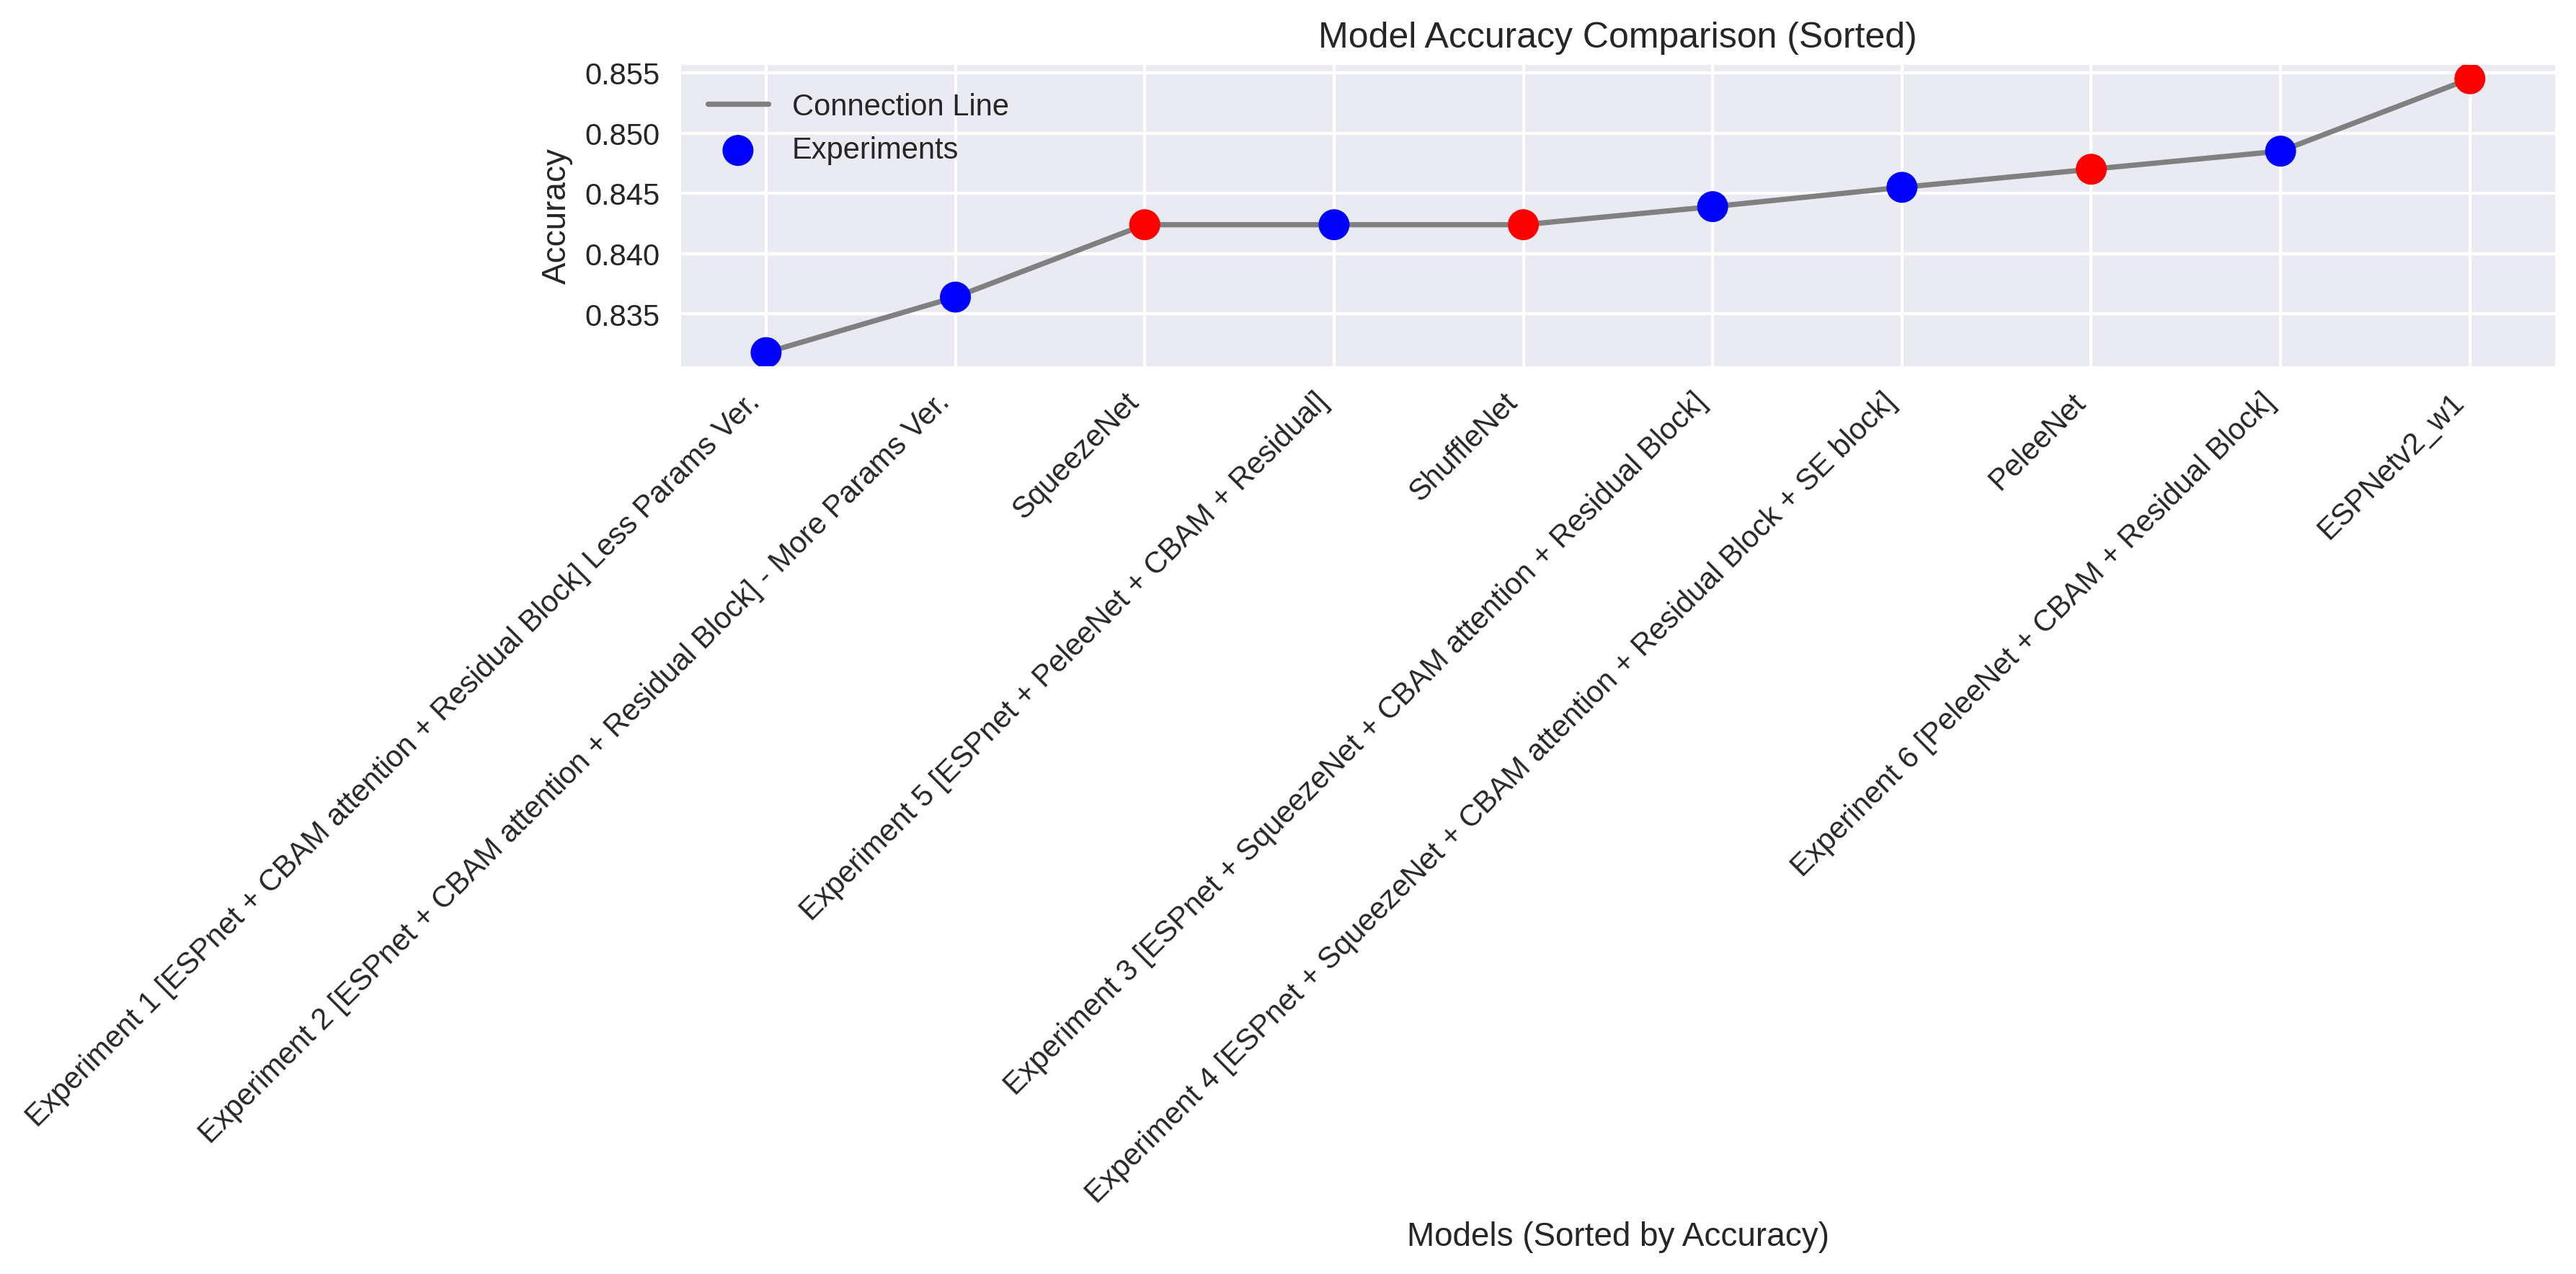


Sorted Parameters Comparison:


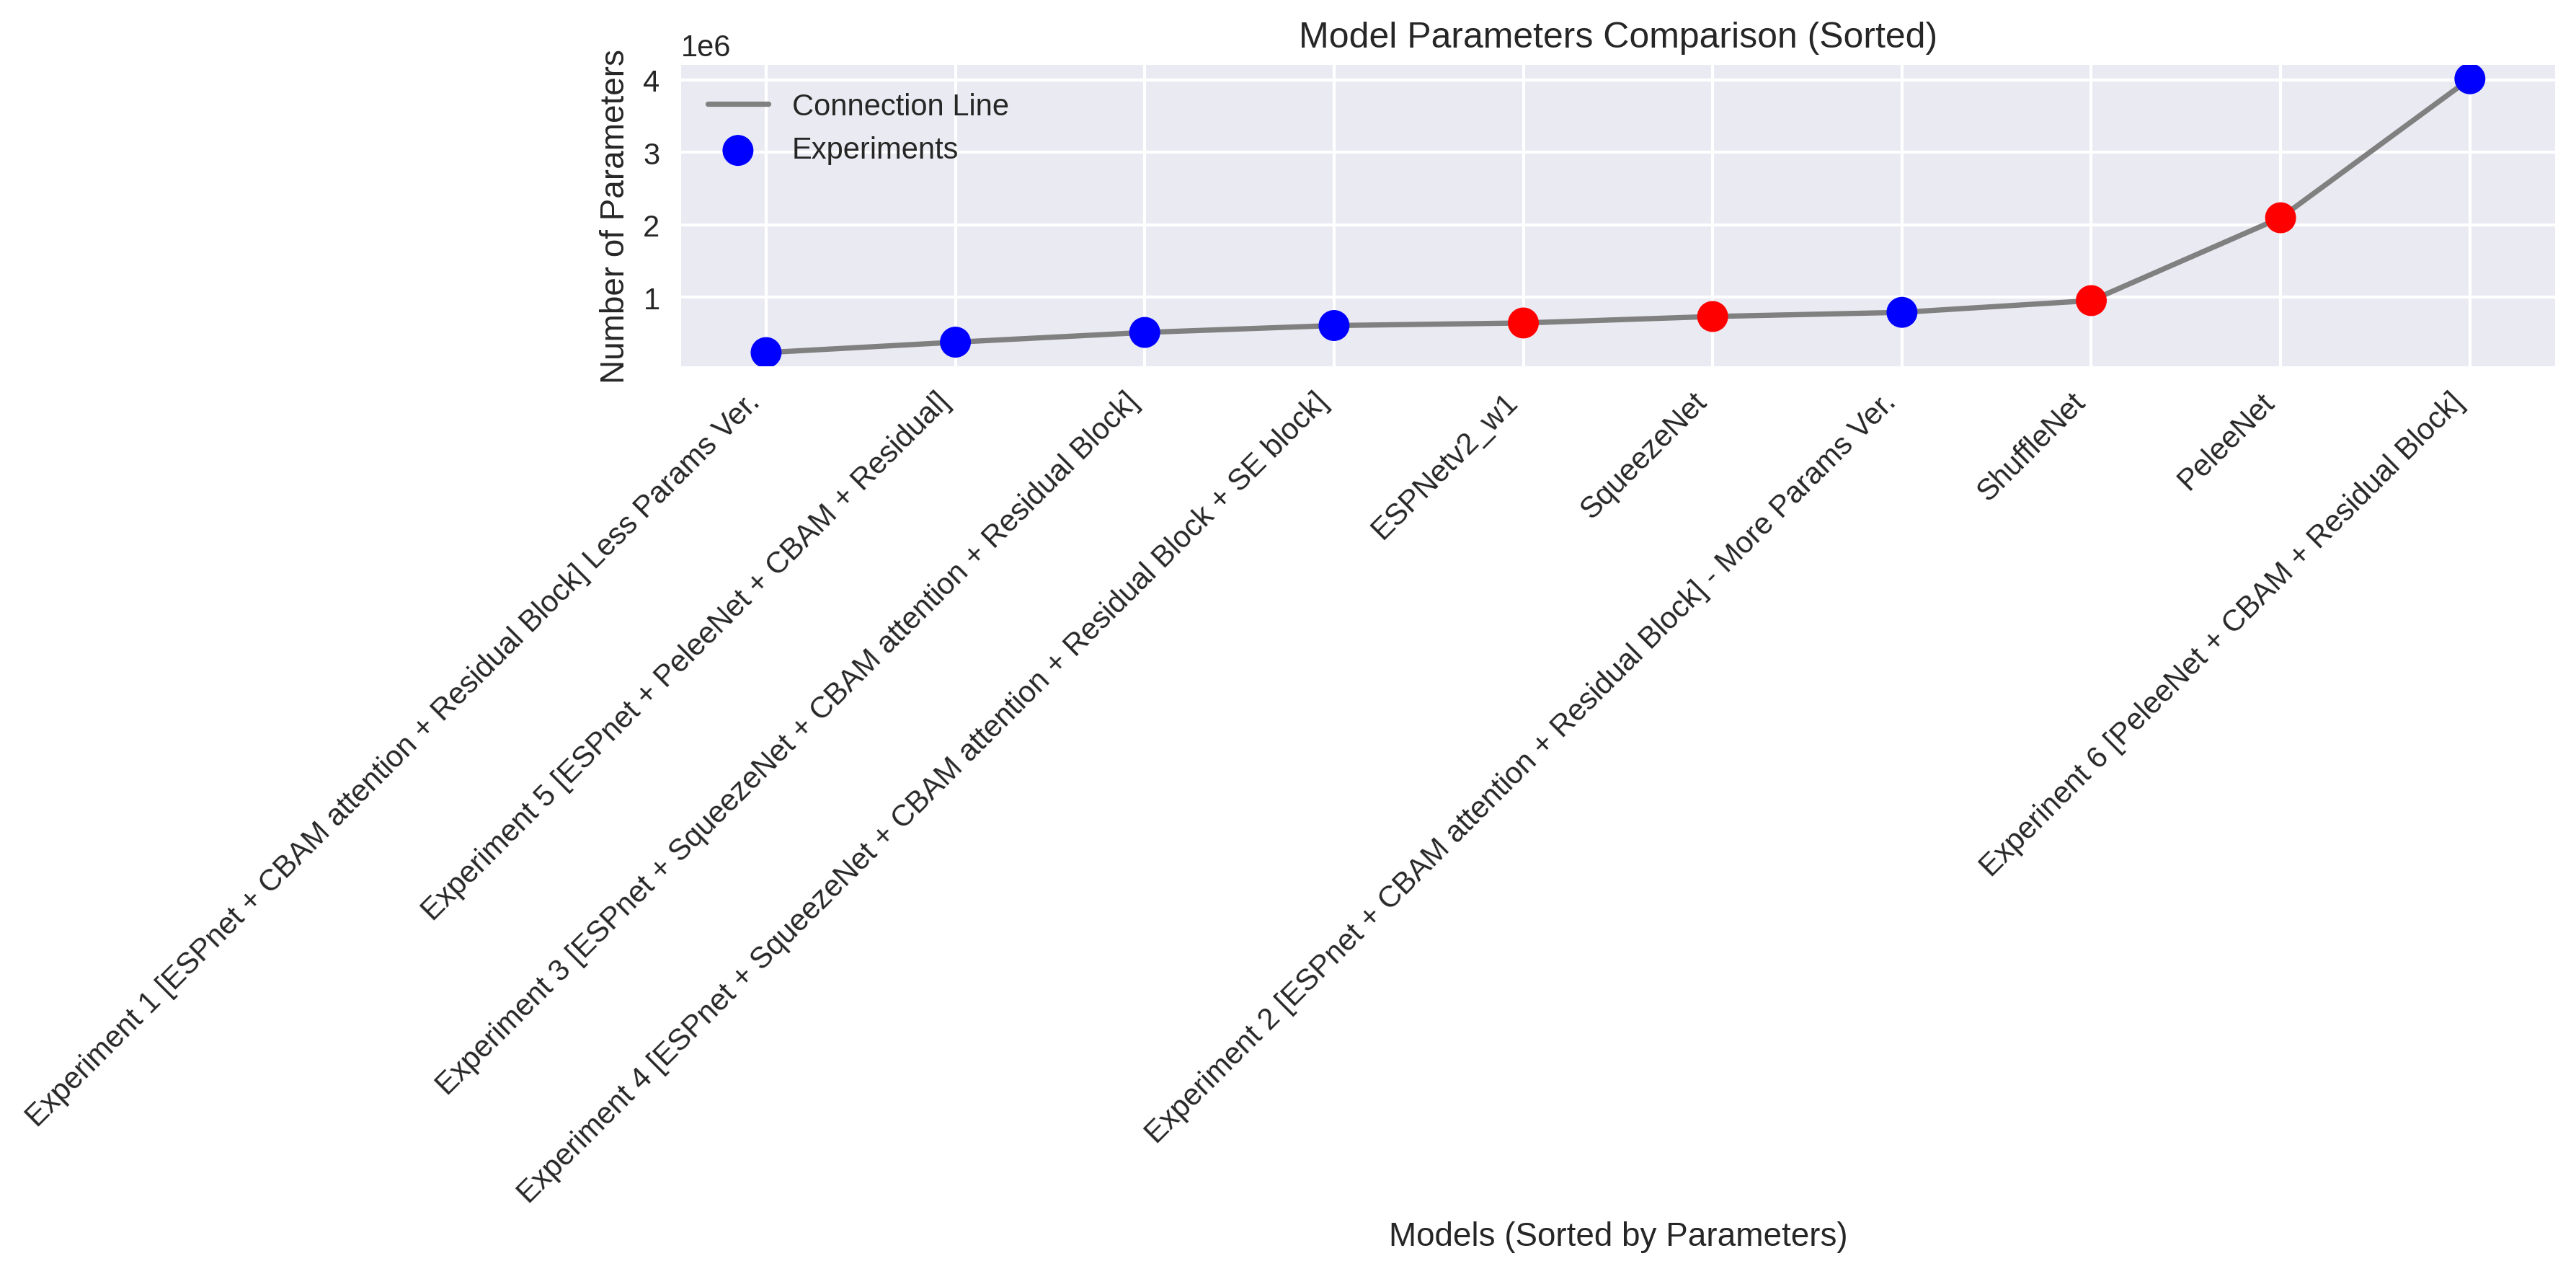


Sorted Efficiency Comparison:


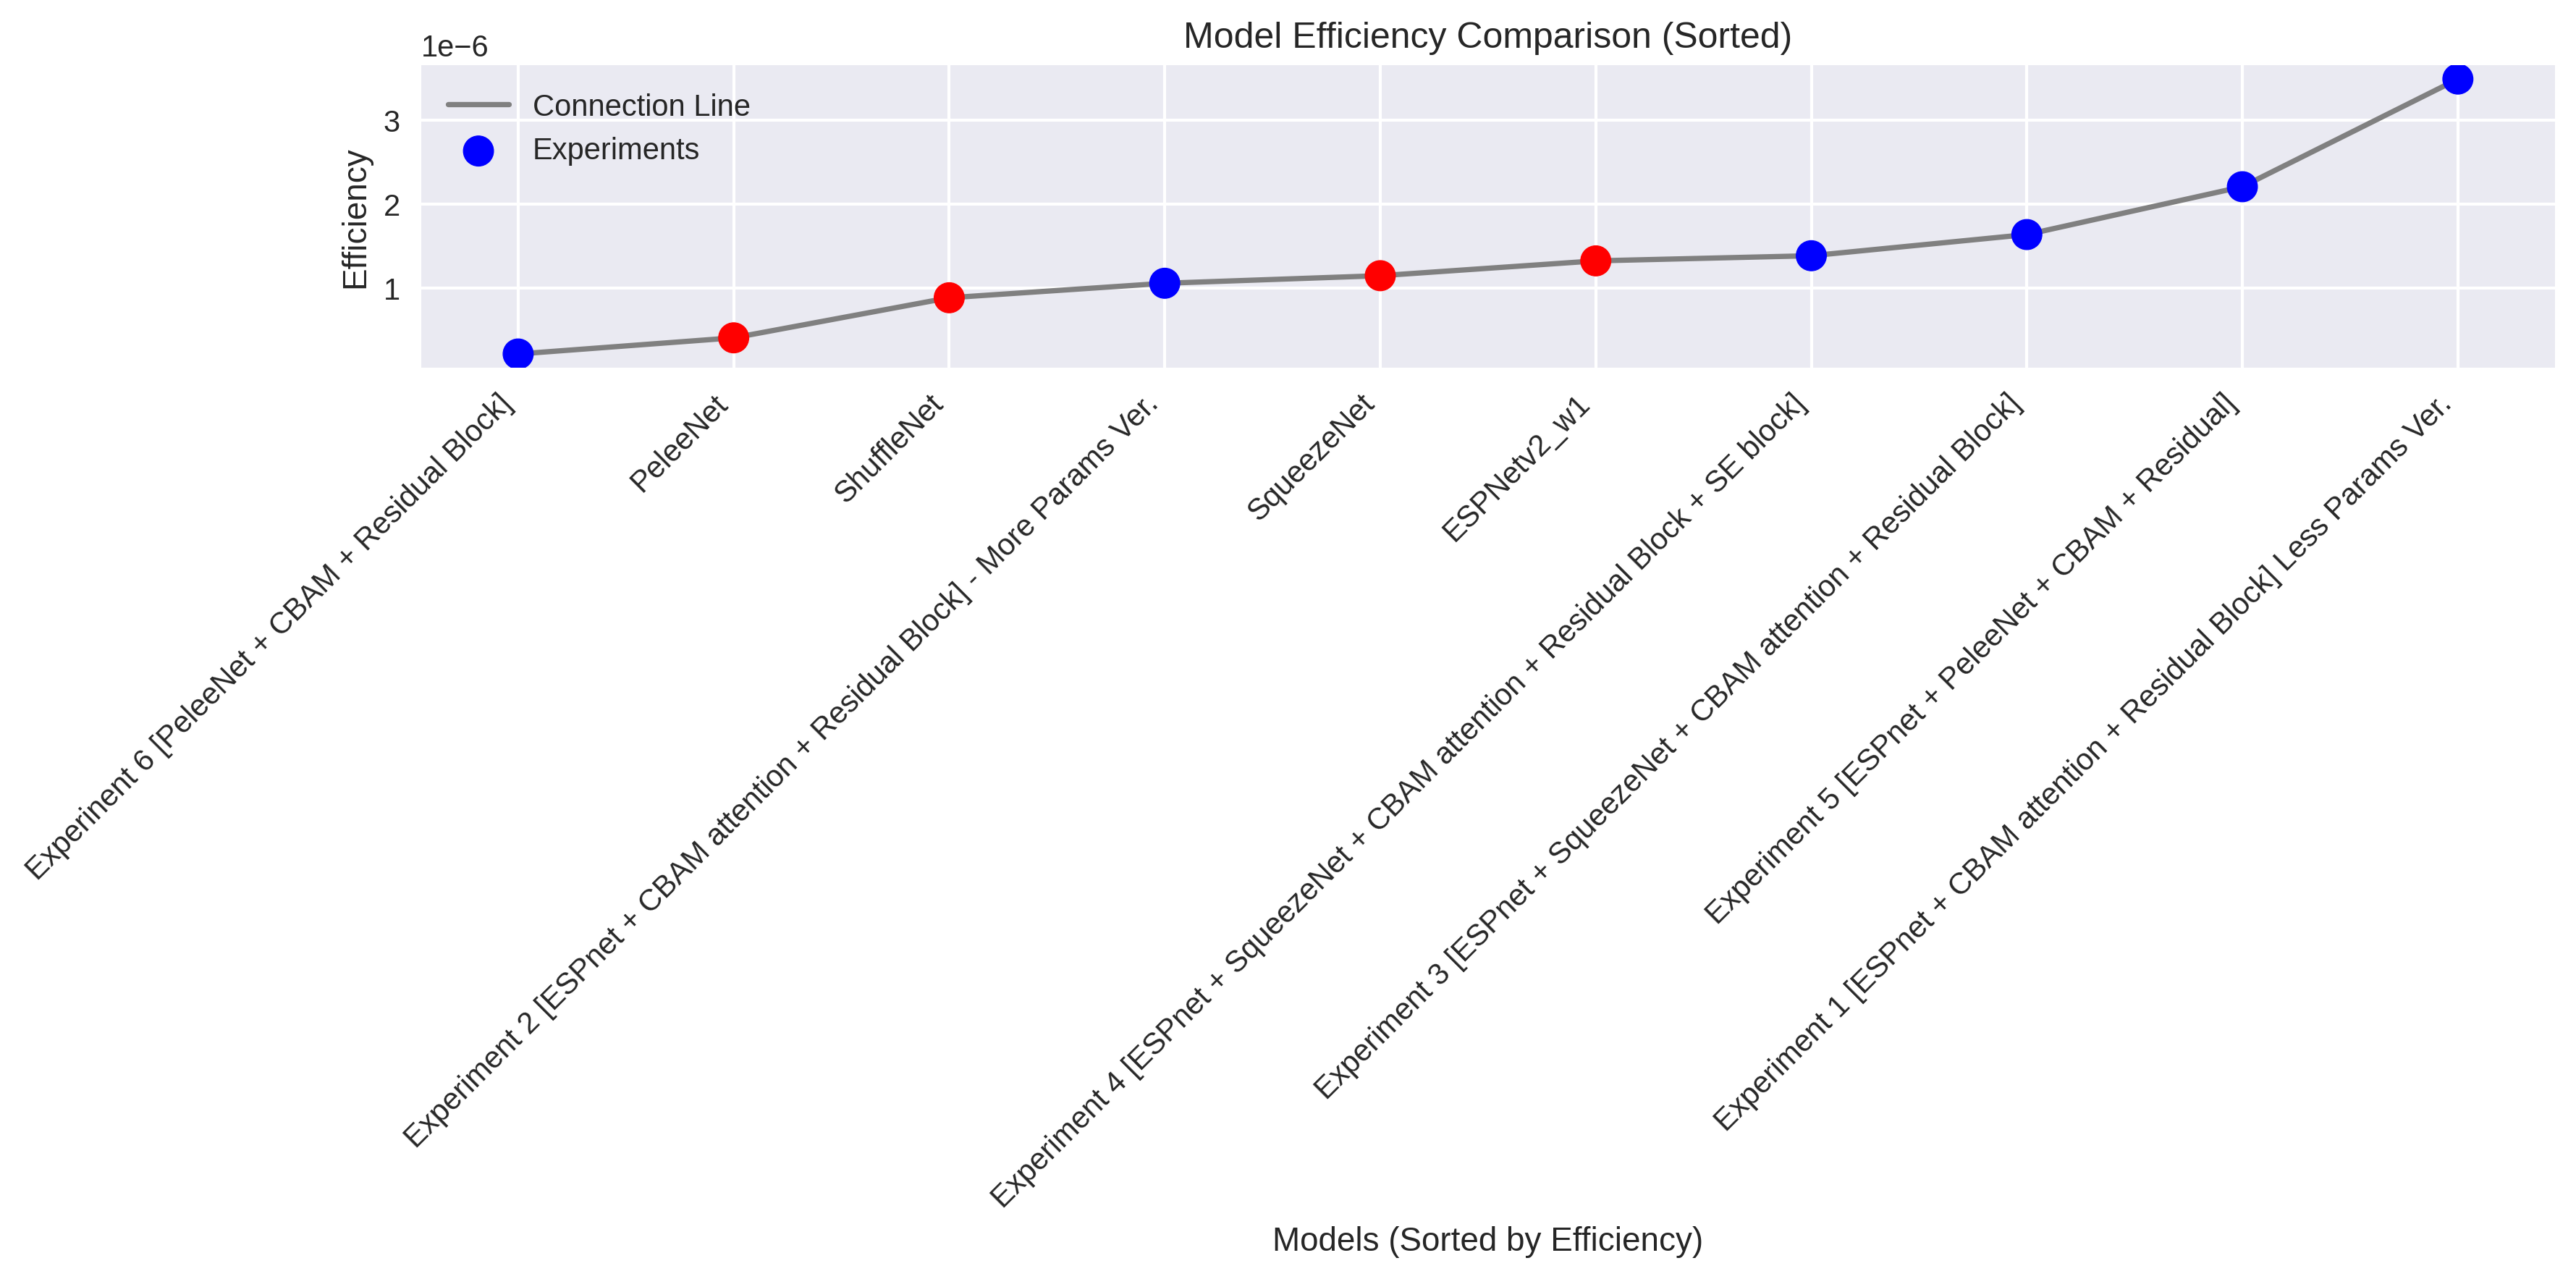

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Experiment results
experiments = {
    'Experiment 1 [ESPnet + CBAM attention + Residual Block] Less Params Ver.': {'num_params': 238610, 'test_accuracy': 0.8318},
    'Experiment 2 [ESPnet + CBAM attention + Residual Block] - More Params Ver.': {'num_params': 793820, 'test_accuracy': 0.8364},
    'Experiment 3 [ESPnet + SqueezeNet + CBAM attention + Residual Block]': {'num_params': 516540, 'test_accuracy': 0.8439},
    'Experiment 4 [ESPnet + SqueezeNet + CBAM attention + Residual Block + SE block]': {'num_params': 611942, 'test_accuracy': 0.8455},
    'Experiment 5 [ESPnet + PeleeNet + CBAM + Residual]': {'num_params': 382266, 'test_accuracy': 0.8424},
    'Experinent 6 [PeleeNet + CBAM + Residual Block]': {'num_params': 4016344, 'test_accuracy': 0.8485}
}

# Baseline models
baselines = {
    'ESPNetv2_w1': {'num_params': 647122, 'test_accuracy': 0.8545},
    'SqueezeNet': {'num_params': 736450, 'test_accuracy': 0.8424},
    'PeleeNet': {'num_params': 2098658, 'test_accuracy': 0.8470},
    'ShuffleNet': {'num_params': 956090, 'test_accuracy': 0.8424}
}


all_data = {**experiments, **baselines}
all_names = list(all_data.keys())
all_accuracy = [data['test_accuracy'] for data in all_data.values()]
all_params = [data['num_params'] for data in all_data.values()]
all_efficiency = [acc/params for acc, params in zip(all_accuracy, all_params)]

accuracy_idx = np.argsort(all_accuracy)
params_idx = np.argsort(all_params)
efficiency_idx = np.argsort(all_efficiency)

plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 6))
names_sorted = [all_names[i] for i in accuracy_idx]
accuracy_sorted = [all_accuracy[i] for i in accuracy_idx]
colors = ['red' if name in baselines else 'blue' for name in names_sorted]
plt.plot(range(len(names_sorted)), accuracy_sorted, '-', color='gray', zorder=1)
plt.scatter(range(len(names_sorted)), accuracy_sorted, c=colors, s=100, zorder=2)
plt.title('Model Accuracy Comparison (Sorted)')
plt.xlabel('Models (Sorted by Accuracy)')
plt.ylabel('Accuracy')
plt.xticks(range(len(names_sorted)), names_sorted, rotation=45, ha='right')
plt.grid(True)
plt.legend(['Connection Line', 'Experiments', 'Baselines'])
plt.tight_layout()
plt.savefig('accuracy_comparison_sorted.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(12, 6))
names_sorted = [all_names[i] for i in params_idx]
params_sorted = [all_params[i] for i in params_idx]
colors = ['red' if name in baselines else 'blue' for name in names_sorted]
plt.plot(range(len(names_sorted)), params_sorted, '-', color='gray', zorder=1)
plt.scatter(range(len(names_sorted)), params_sorted, c=colors, s=100, zorder=2)
plt.title('Model Parameters Comparison (Sorted)')
plt.xlabel('Models (Sorted by Parameters)')
plt.ylabel('Number of Parameters')
plt.xticks(range(len(names_sorted)), names_sorted, rotation=45, ha='right')
plt.grid(True)
plt.legend(['Connection Line', 'Experiments', 'Baselines'])
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig('parameters_comparison_sorted.png', dpi=300, bbox_inches='tight')
plt.close()

plt.figure(figsize=(12, 6))
names_sorted = [all_names[i] for i in efficiency_idx]
efficiency_sorted = [all_efficiency[i] for i in efficiency_idx]
colors = ['red' if name in baselines else 'blue' for name in names_sorted]
plt.plot(range(len(names_sorted)), efficiency_sorted, '-', color='gray', zorder=1)
plt.scatter(range(len(names_sorted)), efficiency_sorted, c=colors, s=100, zorder=2)
plt.title('Model Efficiency Comparison (Sorted)')
plt.xlabel('Models (Sorted by Efficiency)')
plt.ylabel('Efficiency')
plt.xticks(range(len(names_sorted)), names_sorted, rotation=45, ha='right')
plt.grid(True)
plt.legend(['Connection Line', 'Experiments', 'Baselines'])
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig('efficiency_comparison_sorted.png', dpi=300, bbox_inches='tight')
plt.close()

from IPython.display import Image, display

print("Sorted Accuracy Comparison:")
display(Image(filename='accuracy_comparison_sorted.png'))
print("\nSorted Parameters Comparison:")
display(Image(filename='parameters_comparison_sorted.png'))
print("\nSorted Efficiency Comparison:")
display(Image(filename='efficiency_comparison_sorted.png'))